# Project 1 

In [3]:
%matplotlib notebook
%load_ext line_profiler
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
sys.path.insert(0, '../src/')
import turbo
from mpl_toolkits.mplot3d import Axes3D  # NOQA: F401 unused import
from resources import franke
from sampler import Sampler
import fysstatistics as statistics
from itertools import product
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from runner import Runner
from fysstatistics import Regressor, Ridge, Lasso
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm
from modelselection import kfold_indices
from pathlib import Path
#plt.style.use('ggplot')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Plot settings

In [4]:
fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
fig_path = Path("../latex/figures")

plt.rc('text', usetex=True)
fig_opts = {'font.size' : 10,
            #'font.family': 'monospace',
        'axes.labelsize' : 10,
        'font.size' : 10,
        'text.fontsize' : 10,
        'legend.fontsize': 10,
        'xtick.labelsize' : 8,
        'ytick.labelsize' : 8,
       }
plt.rc('font', family='serif')
plt.rc(fig_opts)

## Franke Visualization

<IPython.core.display.Javascript object>


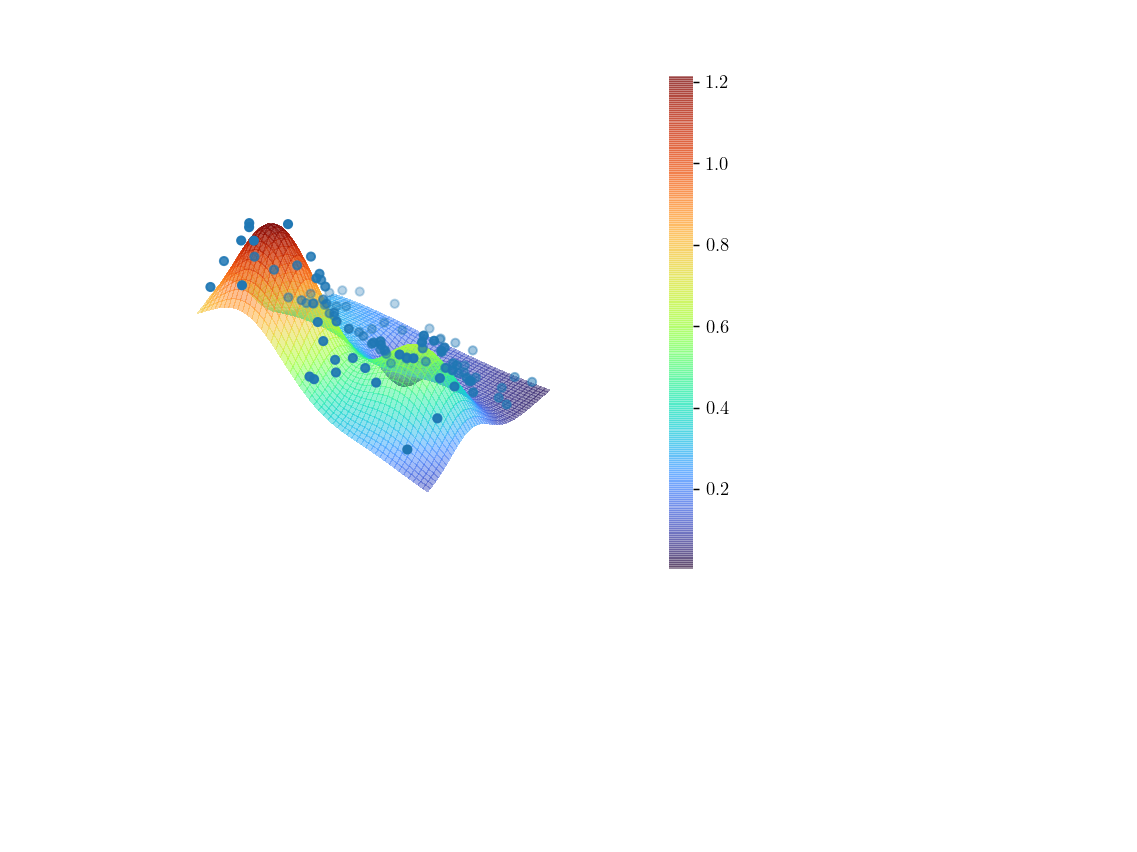

In [12]:
# Truth
x = np.linspace(0, 1)
y = np.linspace(0, 1)
X_true, Y_true = np.meshgrid(x, y)
Z_true = franke(X_true, Y_true)

# Noisy data
x_noise = np.linspace(0, 1, 50)
y_noise = np.linspace(0, 1, 50)
#X_noise, Y_noise = np.meshgrid(x, y)
#Z_noise = franke(X_noise, Y_noise)
#Z_noise += np.random.normal(0, 0.1, Z_noise.shape)
x = np.random.random(100)
y = np.random.random(100)
z = franke(x, y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X_true, Y_true, Z_true, cmap='turbo',
                          antialiased=False, linewidth=0, alpha=0.5)
#ax.scatter(X_noise, Y_noise, Z_noise, s=1)
ax.scatter(x, y, z+0.1)
ax.set_axis_off()
#remove_panes(ax)
cb = fig.colorbar(surface)
cb.outline.set_linewidth(0)

<IPython.core.display.Javascript object>


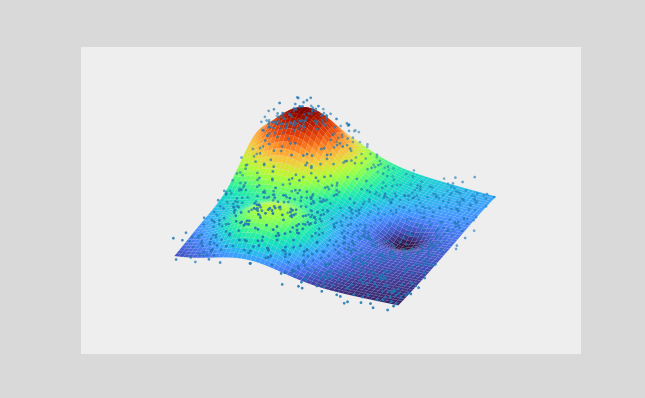

In [49]:
from sampler import Sampler
np.random.seed(1)
sampler = Sampler(franke)
sampler.set_noise(0.1)
(x_noise, y_noise), z_noise = sampler.sample(1000)


with plt.style.context('rapport'):
    fig = plt.figure(figsize=1.5*np.asarray(fig_size))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X_true, Y_true, Z_true, cmap='turbo',
                              antialiased=True, zorder=1, linewidth=0)
    ax.scatter(x_noise, y_noise, z_noise, s=1)
    ax.view_init(elev=40, azim=25)
    ax.set_axis_off()
    #ax.margins(-0.4, -0.4, 0)
    #cb = fig.colorbar(surface)
    #cb.outline.set_linewidth(0)
    fig.savefig(fig_path / "franke.png", dpi=300, transparent=True)

<IPython.core.display.Javascript object>


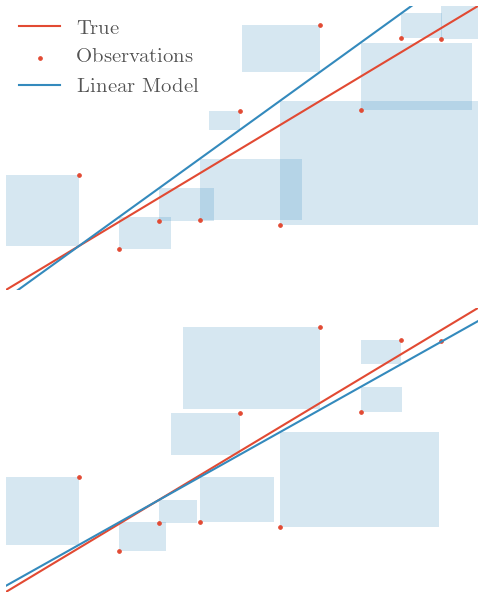

In [49]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

np.random.seed(1)
def fy(x):
    return x
def fyerr(x):
    return fy(x) + np.random.normal(size=x.shape, scale=0.2)
def fywrong(x):
    return 1.2*x

with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize=(fig_size[0], 2*fig_size[1]),
                           nrows=2, constrained_layout=True)
    fig.patch.set_visible(False)
    x = np.linspace(0, 1, 10)
    X = np.linspace(-1, 2, 10)
    obs = fyerr(x)
    linreg = Regressor([x], obs)
    linreg.fit([1])
    yhat = linreg.predict([x])
    Yhat = linreg.predict([X])
    
    ax[0].plot(X, fy(X), '-', label='True')
    ax[1].plot(X, fy(X), '-')
    ax[1].plot(X, Yhat, label='Linear Model')
    ax[0].plot(X, fywrong(X))
    
    boxes = []
    for _x, _y, _yh in zip(x, obs, yhat):
        dy =_yh - _y 
        boxes.append(Rectangle((_x, _y), dy, dy))
    pc = PatchCollection(boxes, alpha=0.2)
    boxes = []
    ax[1].add_collection(pc)
    for _x, _y, _yh in zip(x, obs, fywrong(x)):
        dy =_yh - _y 
        boxes.append(Rectangle((_x, _y), dy, dy))
    pc = PatchCollection(boxes, alpha=0.2)
    ax[0].add_collection(pc)
    ax[1].scatter(x, obs, s=3)
    ax[0].scatter(x, obs, label='Observations', s=3)
    ax[0].set_xlim([-0.2, 1.1])
    ax[0].set_ylim([-0.2, 1.1])
    ax[1].set_xlim([-0.2, 1.1])
    ax[1].set_ylim([-0.2, 1.1])
    ax[1].axis('off')
    ax[0].axis('off')
    fig.legend(loc=2, frameon=False)
    fig.savefig(fig_path / "leastsquares.png", dpi=300, transparent=True)

## Performing linear regression

The Franke function is a function of two variables, so we need to use a bit more complicated regression. The Vandermonde should contain $n + m + 1$ variables where the constants are combined into one, or more generally $1+\Sigma_{i=1}^{i\le k}n_i$ for $k$ variables of order $n_i$. 

<IPython.core.display.Javascript object>


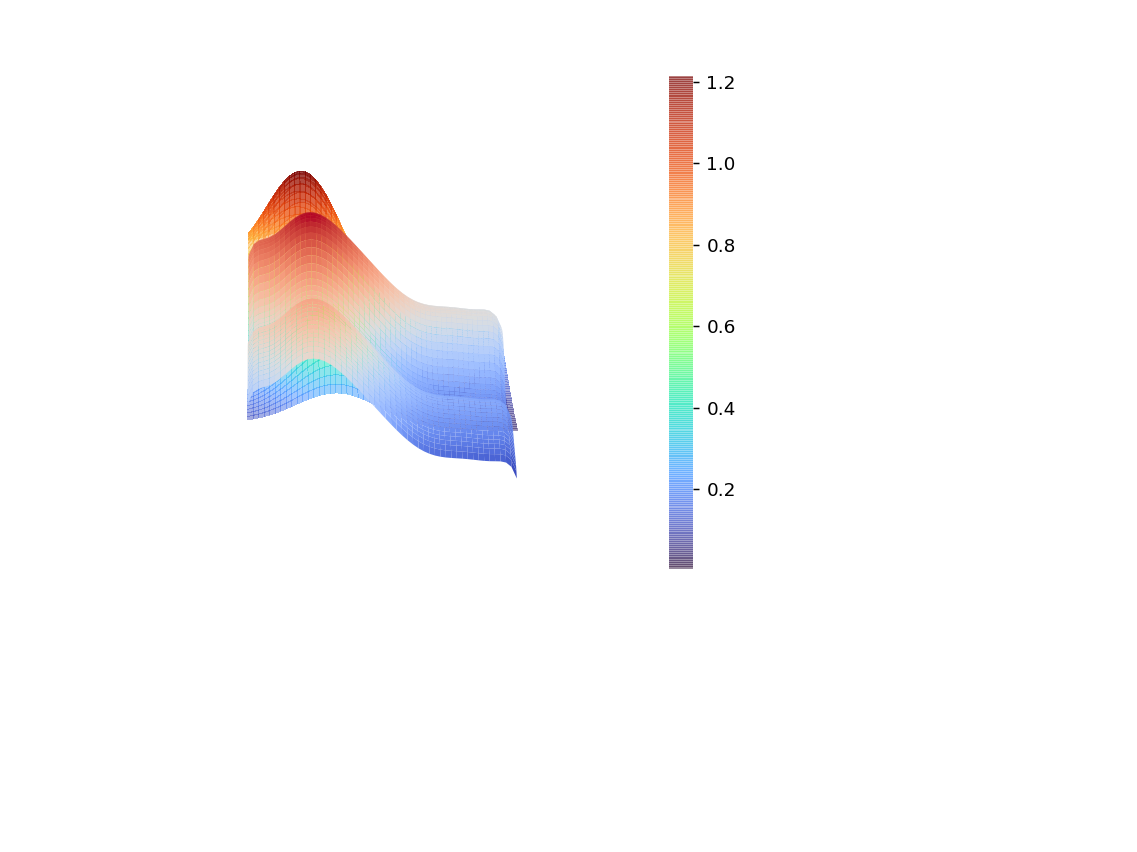

[[ 4.15380883e-01  7.13498380e-01]
 [-1.62815565e+00  1.24954098e+01]
 [-2.39092796e+02  7.47836707e+01]
 [-9.98516490e+02  2.27844080e+03]
 [-1.20875828e+04  6.83297991e+03]
 [-2.71807246e+04  3.85188355e+04]
 [-7.74142438e+04  6.53678585e+04]
 [-9.60896069e+04  9.94300882e+04]
 [-7.93901692e+04  8.43860326e+04]
 [-4.06718147e+04  3.59345777e+04]
 [-7.04369710e+03  8.28024274e+03]
 [-2.27156105e+00  1.16916056e+01]
 [-2.60934549e+02  5.22899217e+01]
 [-4.47313050e+02  2.84084067e+03]
 [-1.66191473e+04  2.44068892e+03]
 [-8.92757272e+03  5.74813203e+04]
 [-1.23799613e+05  2.09755900e+04]
 [-3.08663139e+04  1.67958159e+05]
 [-1.39542631e+05  2.74519970e+04]
 [-1.34870580e+04  6.48215033e+04]
 [-1.28915994e+04  2.80952828e+03]]


In [10]:
sampler = Sampler(franke)
sampler.set_noise(0.1)
(x_noise, y_noise), z_noise = sampler.sample(1000)

fitter = statistics.Regressor([x_noise, y_noise], z_noise)
fitter.fit([10, 10])

ẑ = fitter.predict([X_true, Y_true])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X_true, Y_true, Z_true, cmap='turbo', 
                          antialiased=False, linewidth=0, alpha=0.5)
ax.plot_surface(X_true, Y_true, ẑ, cmap='coolwarm')
ax.set_axis_off()
cb = fig.colorbar(surface)
cb.outline.set_linewidth(0)
print(fitter.ci(0.95))

## Ridge Regression

<IPython.core.display.Javascript object>


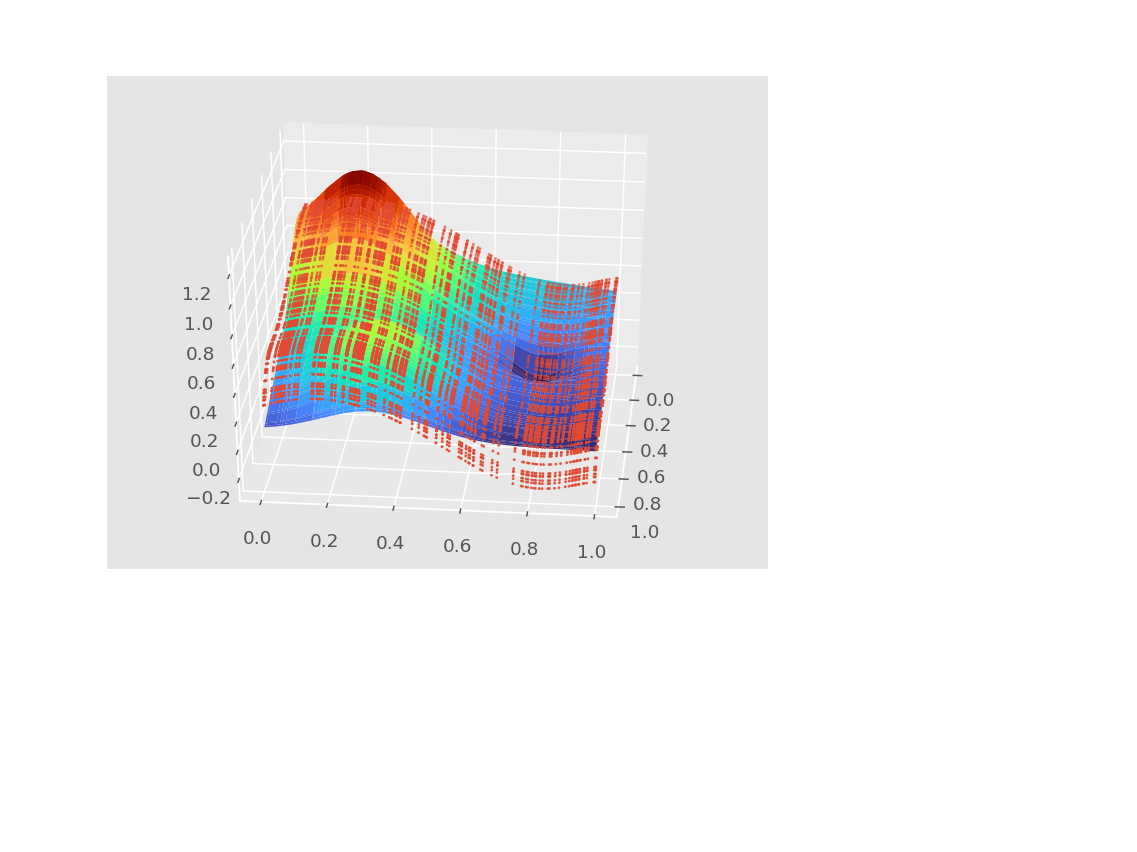

In [161]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
sampler = Sampler(franke)
sampler.set_noise(0.1)
(X, Y), Z = sampler.sample(100)
V = statistics.vandermonde([X, Y], [[1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]])
Xtrain, Xtest, ytrain, ytest = train_test_split(V, Z.flatten())
ridge = Ridge(alpha=1.2)
ridge.fit(Xtrain, ytrain)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sampler.set_noise(0)
(X, Y), Z = sampler.sample(100)
ax.plot_surface(X, Y, Z, cmap='turbo')
V = statistics.vandermonde([X, Y], [[1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]])
y = ridge.predict(V)
ax.scatter(X, Y, y, s=1)

In [ ]:
sridge = statistics.Ridge()

## K-fold split

## Random sampling

<IPython.core.display.Javascript object>


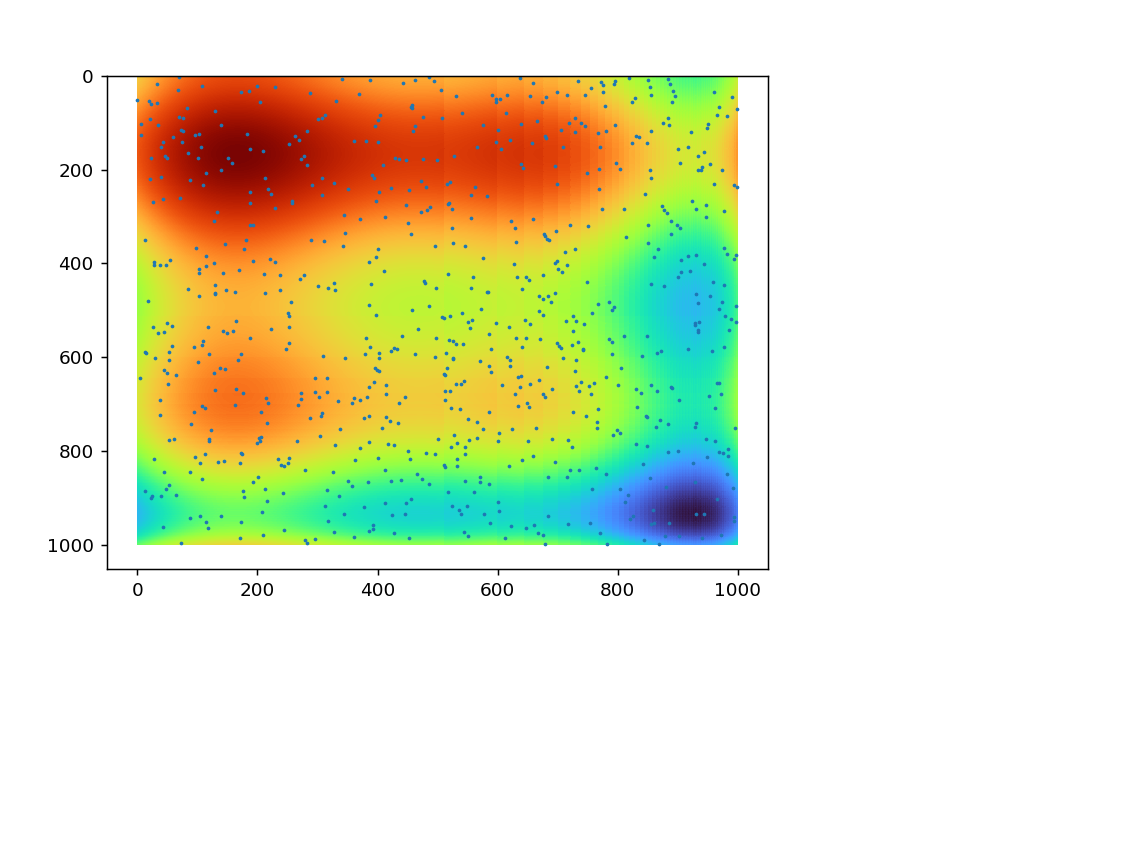

<IPython.core.display.Javascript object>


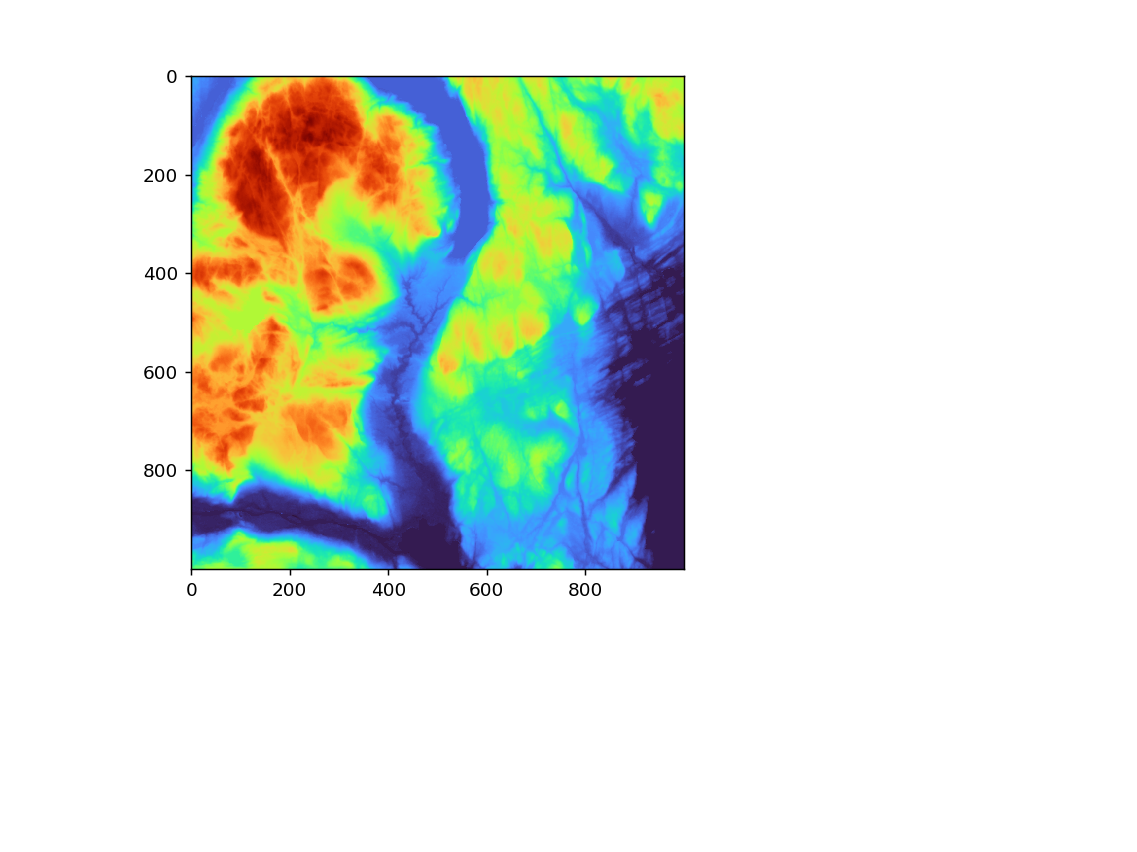

In [28]:
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain = imread('../resources/n59_e010_1arc_v3.tif')
N = 1000
x = np.random.random_integers(0, N, 1000)
y = np.random.random_integers(0, N, 1000)
sampler = Sampler(terrain[:N, :N])
(x, y), z = sampler.sample(800)
#x = np.arange(N)
#y = np.arange(N)
#x.sort()
#y.sort()

reg = statistics.Regressor([x, y], z)
reg.fit([7, 7], interactions=False)
#print(reg.vandermonde)
X, Y = np.meshgrid(np.arange(N), np.arange(N))
Z = reg.predict([X, Y])
#print(reg.β)

subterrain = terrain[:N, :N]
vmin, vmax = np.min(subterrain), np.max(subterrain)
fig, ax = plt.subplots()
ax.pcolormesh(X, Y, Z, cmap='turbo')
ax.scatter(x, y, s=1)
ax.invert_yaxis()

fig2, ax2 = plt.subplots()
ax2.imshow(subterrain, cmap='turbo')

# Bias Variance Tradeoff

In [2]:
from ensemble import Ensemble

In [27]:
sampler = Sampler(franke)
sampler.set_noise(0.1)
ensemble = Ensemble(sampler, order=15, sample_size=50, num_members=1000)
ensemble.run(None)

100%|██████████| 1000/1000 [00:14<00:00, 69.19it/s]


<IPython.core.display.Javascript object>


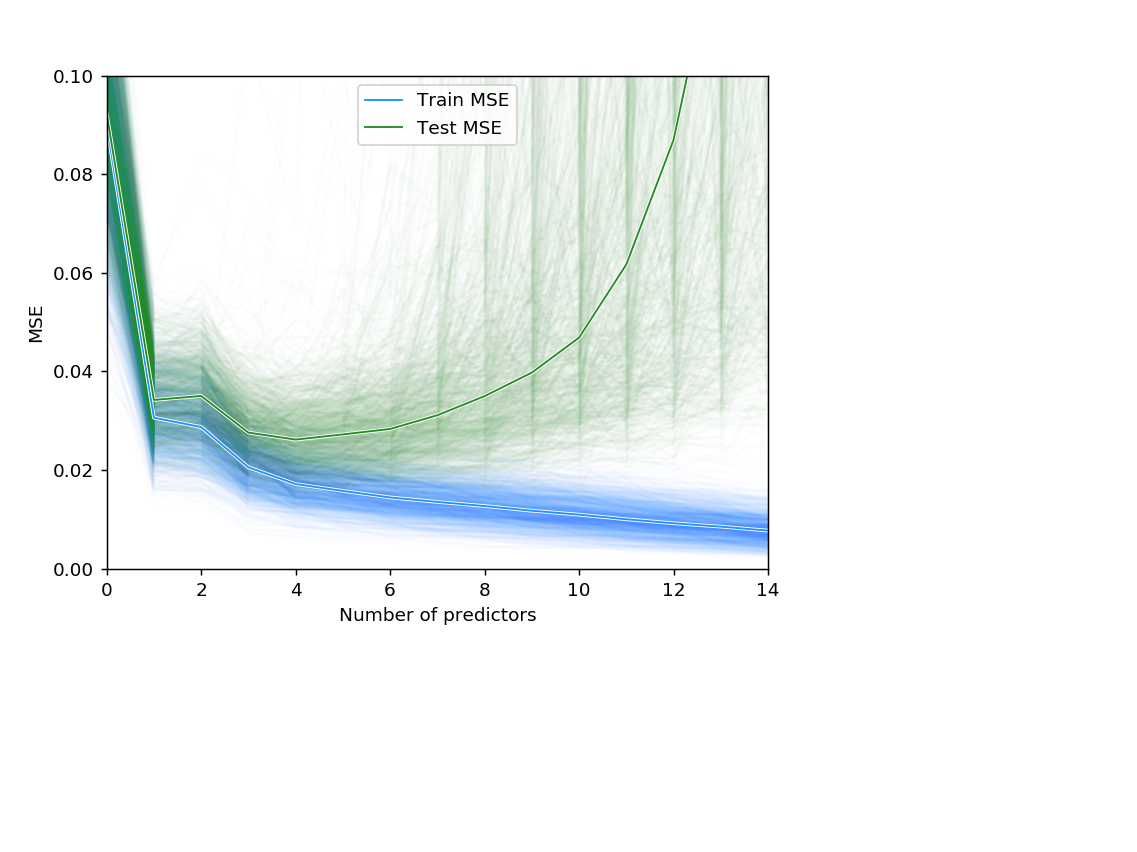

(0, 14)

In [39]:
fig, ax = ensemble.plot()
ax.set_ylim(0.0, 0.1)
ax.set_xlim(0, 14)

# Real World Data

<IPython.core.display.Javascript object>


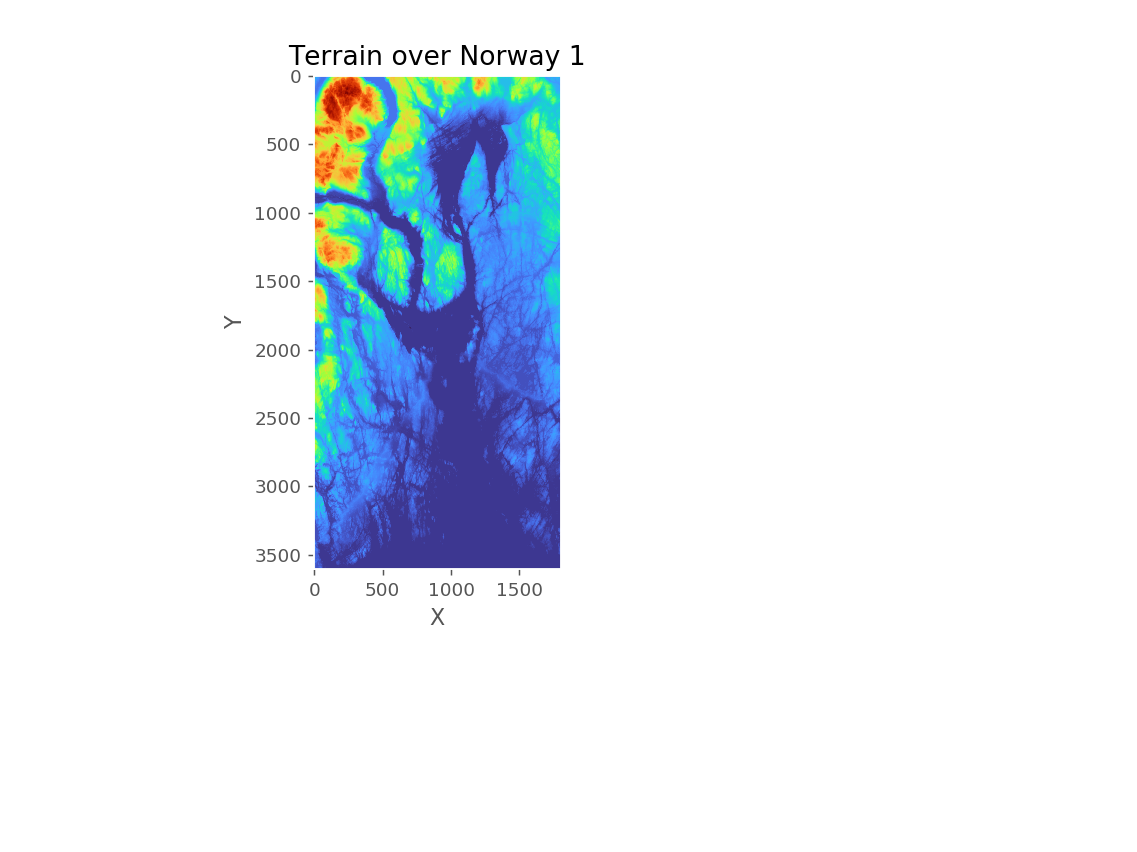

In [5]:
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain = imread('../resources/n59_e010_1arc_v3.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='turbo')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()

#print(terrain.shape)
#terrain_sampler = Sampler(terrain)
#(I, J), val = terrain_sampler.sample()
#plt.imshow(val.T, cmap='turbo')

<IPython.core.display.Javascript object>


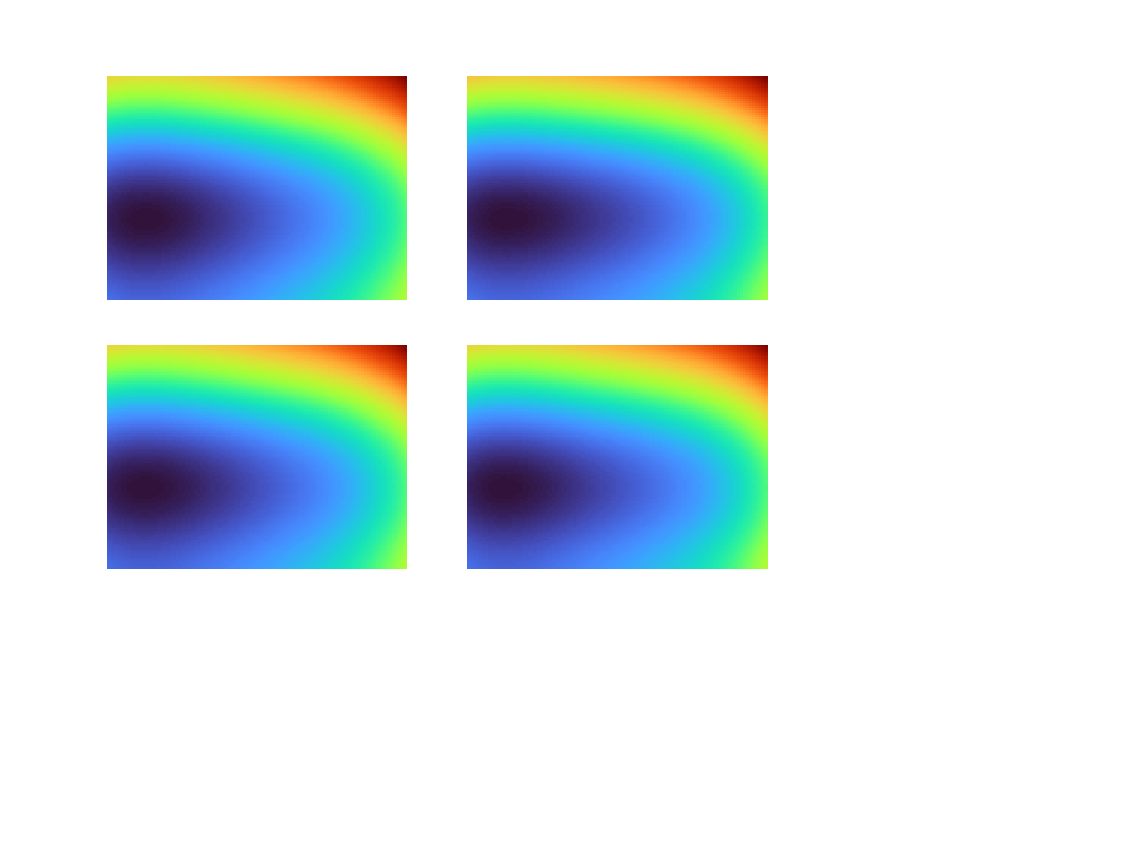

<IPython.core.display.Javascript object>


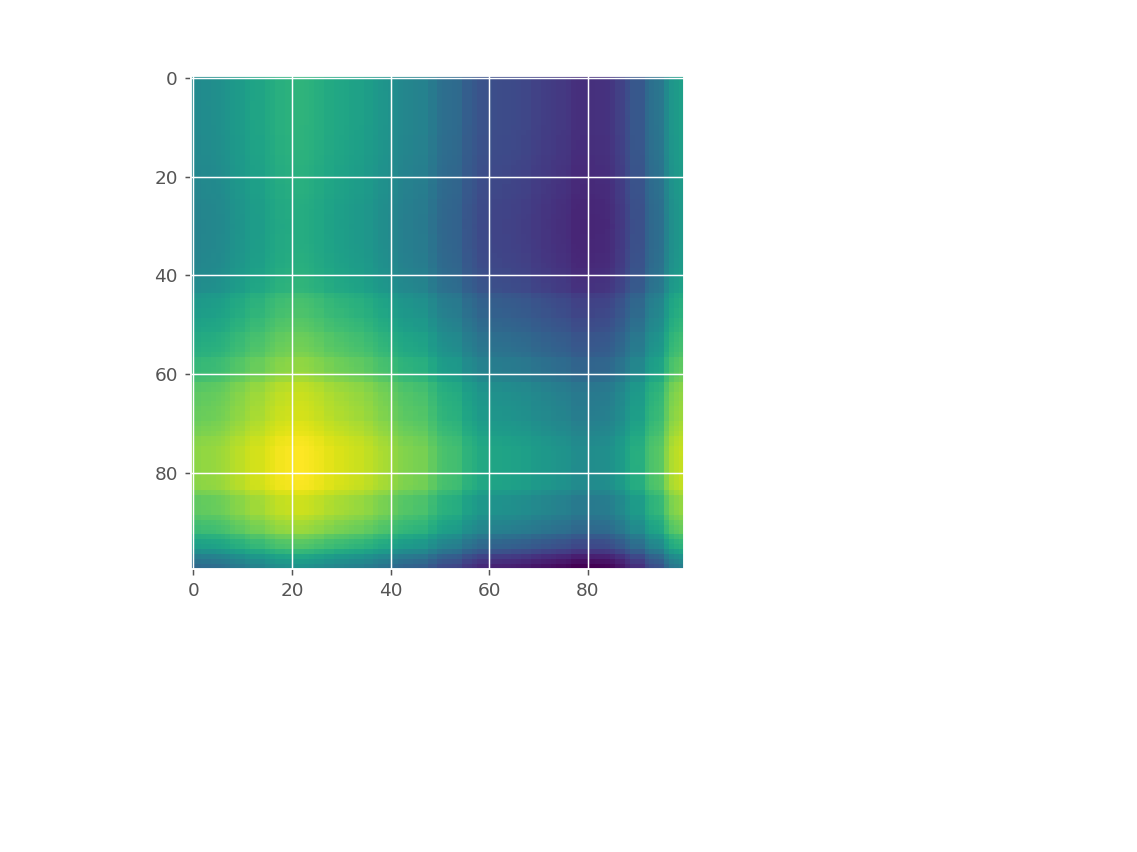

In [15]:
from modelselection import kfold
terrain = terrain[0:100, 0:100]
x, y = np.arange(terrain.shape[0]), np.arange(terrain.shape[1])
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(2,2)
i = 0
kmodel = kfold([X, Y], terrain[X, Y], k=4, shuffle=True)
for (xtrain, xtest), (ytrain, ytest) in kmodel:
    regressor = statistics.Regressor(xtrain, ytrain)
    regressor.fit([5, 5])
    ax[i//2, i%2].pcolormesh(X, Y, regressor.predict([X, Y]), cmap='turbo')
    ax[i//2, i%2].axis('off')
    i += 1

fig2, ax2 = plt.subplots()
ax2.imshow(terrain, cmap='turbo')

# Exercises

## Part a)

<IPython.core.display.Javascript object>


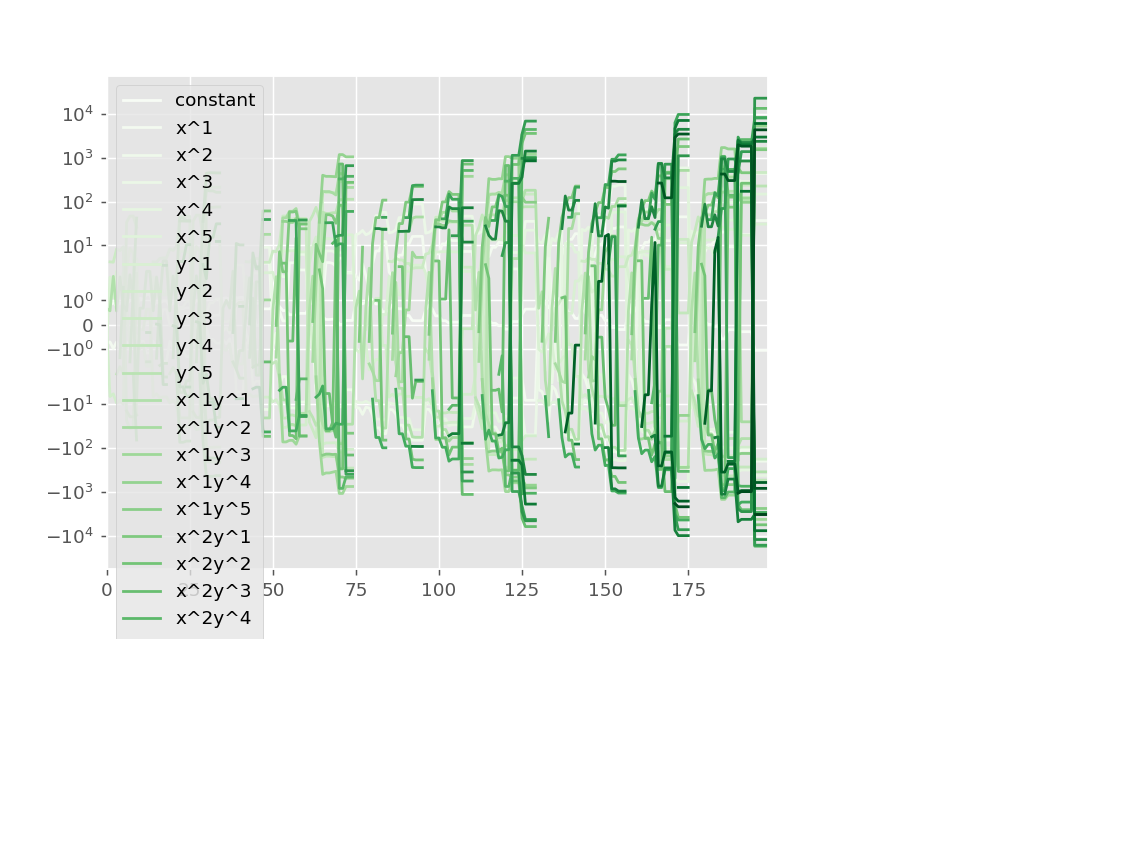

In [391]:
with plt.style.context("ggplot"):
#    fig, ax = plt.subplots()
#    for term in df.columns:
#        ax.plot(np.asarray(df[term]))
    ax = df.plot(cmap='Greens')
    ax.set_yscale('symlog')

In [15]:
np.random.seed(1)
sampler = Sampler(franke)
sampler.set_noise(0.1)
runner = Runner(sampler, Regressor, find_prediction_error=True)
runner.sample(100)
runner.run([5, 5], single=False, use_interactions=True)

<IPython.core.display.Javascript object>


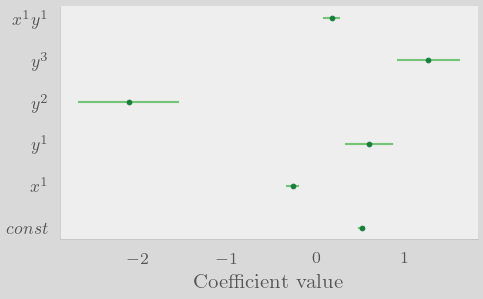

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [7]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(constrained_layout=True)
    _, ax = runner.ci_plot(ax=ax)
    #ax.set_xscale("symlog")
    fig.savefig(fig_path / "ols_ci.png", dpi=300, transparent=True,
                bbox_inches='tight')

<IPython.core.display.Javascript object>


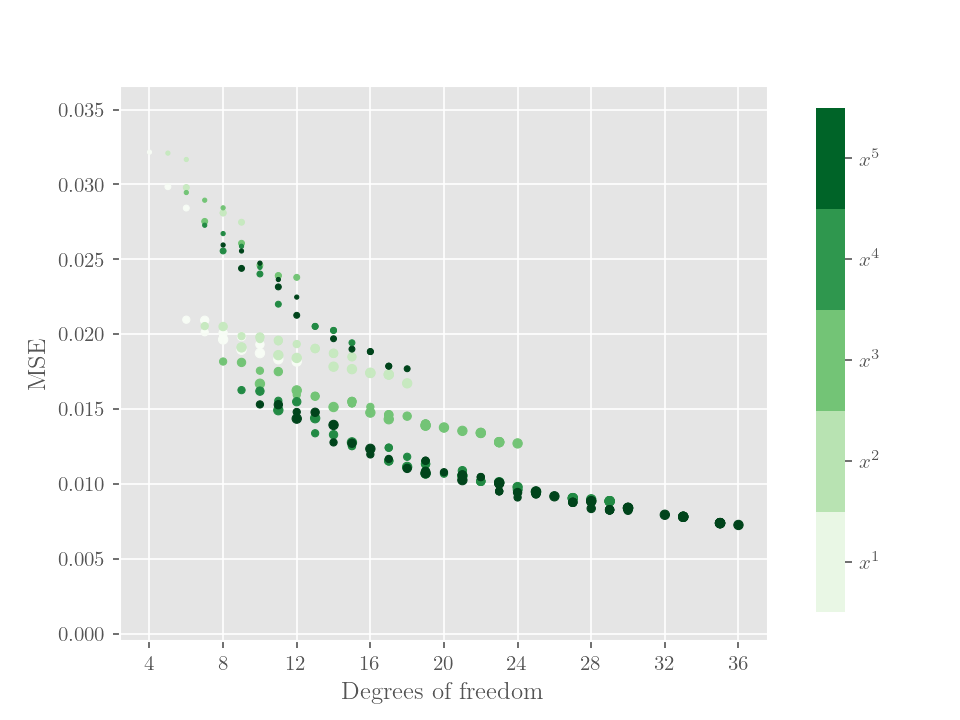

In [5]:
from matplotlib.lines import Line2D
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=False)
    s = 20*runner.df['max y']/max(runner.df['max y'])
    s = np.asarray(s, dtype=float)
    ax.scatter(runner.df['df'], runner.df['MSE train'], cmap='Greens',
               c=runner.df['max x'], s=s)
    #ax.scatter(runner.df['df'], runner.df['MSE test'], cmap='Blues',
    #           c=runner.df['max x'], s=s)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('MSE')
    ax.set_xlabel('Degrees of freedom')
    #ax.set_ylim([0.008, 0.03])
    cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.subplots_adjust(right=0.8)
    bounds = np.array([1, 2, 3, 4, 5, 6])
    cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap='Greens', spacing='proportional',
                 boundaries=bounds, format='%1i', ticks=bounds+0.5)
    #cax.set_ylabel('Order of X')
    cbar.ax.set_yticklabels(f'$x^{s}$' for s in [1, 2, 3, 4, 5])
    cbar.outline.set_linewidth(0)
    c = plt.cm.get_cmap('Greens')(0.5)
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=c, label=f"$y^{l}$", markersize=s)
                      for l, s in zip([1, 2, 3, 4, 5], [2, 4, 6, 8, 10])]
    fig.legend(handles=legend_elements, mode='expand', 
               loc='lower left', ncol=5, frameon=False,
              bbox_to_anchor=(0.0, 1.02, 1, 0.2))
    #fig.savefig(fig_path / "ols_group.png", dpi=300, transparent=True,
    #            bbox_inches='tight')

<IPython.core.display.Javascript object>


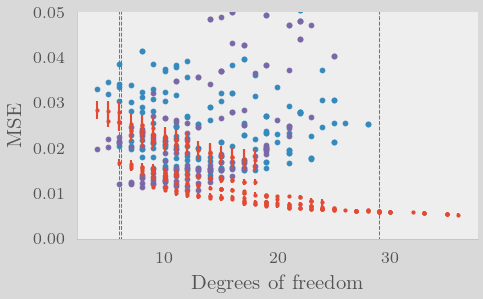

In [50]:
testbest = runner.best_model('test').df()
trainbest = runner.best_model('train').df()
predbest = runner.best_model('pred').df()
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True)
    tr, _, _ = ax.errorbar(runner.df['df'], runner.df['MSE train'], 
                     runner.df['train sd'], label='Train', fmt='o', ms=1,
                          linewidth=1, c="#E24A33")
    te = ax.scatter(runner.df['df'], runner.df['MSE test'], label='Test', s=5,
                   c='#348ABD')
    pr = ax.scatter(runner.df['df'], runner.df['MSE pred'], label='Out of Sample',
                    s=5, c='#7A68A6')
    ax.vlines(trainbest, -1, 0.2, color=tr.get_color(), linewidth=0.5, linestyle='--')
    ax.vlines(testbest, -1, 0.2, color=te.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.vlines(predbest+0.1, -1, 0.2, color=pr.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.set_xlabel("Degrees of freedom")
    ax.set_ylim(0, 0.05)
    ax.set_ylabel("MSE")
    fig.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.02, 1, 0.2))
    #fig.savefig(fig_path / "olsmse.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


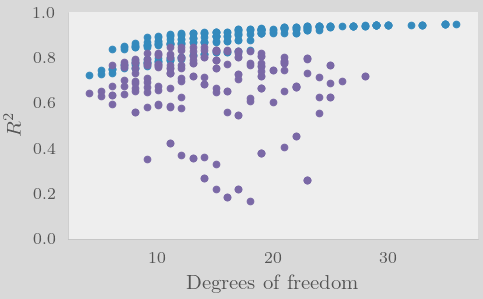

In [59]:
testbest = runner.best_model('test').df()
trainbest = runner.best_model('train').df()
predbest = runner.best_model('pred').df()
with plt.style.context('rapport'):
    fig, ax = plt.subplots(constrained_layout=True)
    tr = ax.scatter(runner.df['df'], runner.df['r2 train'], label='Train', s=10)
    te = ax.scatter(runner.df['df'], runner.df['r2 test'], label='Test', s=10)
   # pr = ax.scatter(runner.df['df'], runner.df['MSE pred'], label='Out of Sample',
   #                 s=5, c='#7A68A6')
   # ax.vlines(trainbest, -1, 0.2, color=tr.get_color(), linewidth=0.5, linestyle='--')
    #ax.vlines(testbest, -1, 0.2, color=te.get_facecolor(), linewidth=0.5, linestyle='--')
   # ax.vlines(predbest+0.1, -1, 0.2, color=pr.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.set_xlabel("Degrees of freedom")
    ax.set_ylim(0, 1)
    ax.set_ylabel(r"$R^2$")
    fig.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.3, 1.02, 1, 0.2))
    fig.savefig(fig_path / "olsr2.png", dpi=300, transparent=True, bbox_inches='tight')

\mathchardef\mhyphen="2D


<IPython.core.display.Javascript object>


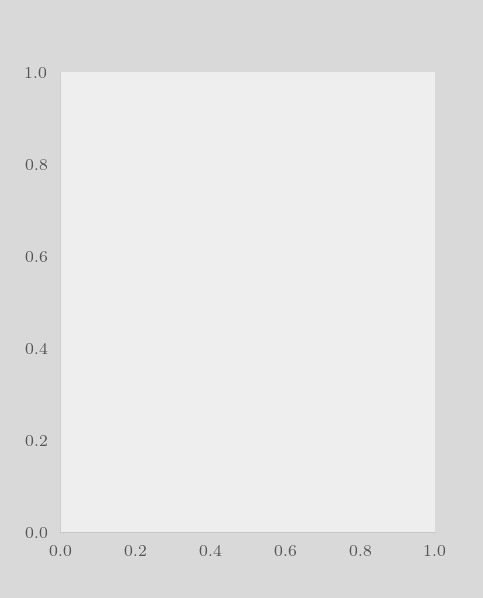

NameError: name 'runner' is not defined

In [8]:
import matplotlib
import re
# create a definition for the short hyphen
matplotlib.rcParams["text.latex.preamble"] = r'\mathchardef\mhyphen="2D'
print(matplotlib.rcParams["text.latex.preamble"])

class MyLogFormatter(matplotlib.ticker.LogFormatterMathtext):
    def __call__(self, x, pos=None):
        # call the original LogFormatter
        rv = matplotlib.ticker.LogFormatterMathtext.__call__(self, x, pos)

        # check if we really use TeX
        if matplotlib.rcParams["text.usetex"]:
            # if we have the string ^{- there is a negative exponent
            # where the minus sign is replaced by the short hyphen
            rv = re.sub(r'-', r'\\mhyphen', rv)

        return rv
with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize=(fig_size[0], 2*fig_size[1]))
    _, ax = runner.coeff_plot(ax=ax)
    ax.xaxis.set_major_formatter(MyLogFormatter())
    #matplotlib.rcParams['axes.unicode_minus'] = True
    ax.tick_params(axis='x', which='major', labelsize=5)
    #fig.savefig(fig_path / "olscoeff.png", dpi=300, transparent=True, bbox_inches='tight')

In [48]:
np.random.seed(1)
sampler = Sampler(franke)
sampler.set_noise(0.1)
runner = Runner(sampler, Regressor, find_prediction_error=False)
runner.sample(100)
runner.run([30, 30], single=False, use_interactions=False)

<IPython.core.display.Javascript object>


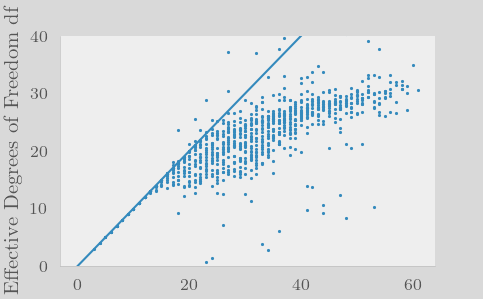

In [85]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    ax.scatter(runner.df['complexity'], runner.df['df'], s=1, label='Models')
    ax.plot([0, 40], [0, 40], label=r'df $= p$')
    ax.set_xlabel('Naive Degrees of Freedom $p$')
    ax.set_ylabel('Effective Degrees of Freedom df')
    ax.set_ylim(0, 40)
    fig.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.2, 1.02, 1, 0.2))
    fig.savefig(fig_path / "effectivedf.png", dpi=300, transparent=True, bbox_inches='tight')

In [41]:
np.random.seed(1)
sampler = Sampler(franke)
sampler.set_noise(0.1)
runner2 = Runner(sampler, Regressor, find_prediction_error=False)
runner2.sample(50)
runner2.run([10, 10], single=False, use_interactions=True)

<IPython.core.display.Javascript object>


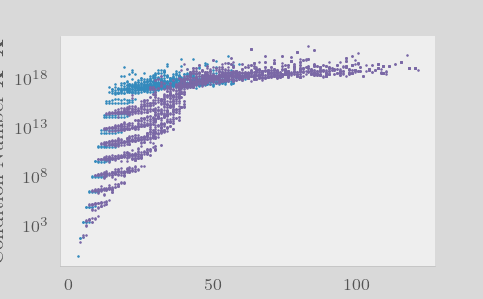

In [77]:
#cond = [np.linalg.cond(r.vandermonde) for r in runner.all_regressors]
#cond2 = [np.linalg.cond(r.vandermonde) for r in runner2.all_regressors]
cond_ols2 = []
for reg in runner2.all_regressors:
    X = reg.vandermonde
    cond_ols2.append(np.linalg.cond(X.T@X))
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    ax.scatter(runner.df['complexity'], cond_ols, s=0.5, label="No interactions")
    ax.scatter(runner2.df['complexity'], cond_ols2, s=0.5, label="Interactions")
    ax.set_xlabel('$p$')
    ax.set_ylabel(r'Condition Number $\mathbf{X}^T\mathbf{X}$')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_ylim(0, 50)
    #ax.set_xlim(0,50)
    fig.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.0, 1.02, 1, 0.2))
    fig.savefig(fig_path / "condition.png", dpi=300, transparent=True, bbox_inches='tight')

In [60]:
np.random.seed(1)
sampler = Sampler(franke)
sampler.set_noise(0.1)
runner_r = Runner(sampler, Ridge, parameter_range=[1e-2], find_prediction_error=False)
runner_r.sample(100)
runner_r.run([30, 30], single=False, use_interactions=False)
runner_l = Runner(sampler, Lasso, parameter_range=[1e-4], find_prediction_error=False)
runner_l.sample(100)
runner_l.run([30, 30], single=False, use_interactions=False)

<IPython.core.display.Javascript object>


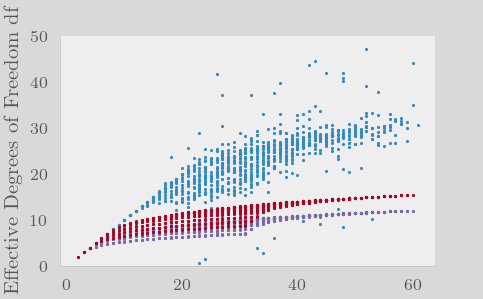

In [81]:
cond_r = [np.linalg.cond(r.vandermonde) for r in runner_r.all_regressors]
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    ax.scatter(runner.df['complexity'], runner.df['df'], s=1, label="OLS")
    ax.scatter(runner_r.df['complexity'], runner_r.df['df'], s=1, label="Ridge")
    ax.scatter(runner_l.df['complexity'], runner_l.df['df'], s=1, label="Lasso")
    #ax.scatter(runner2.df['complexity'], cond2, s=1, label="Interactions")
    ax.set_xlabel('Naive Degrees of Freedom $p$')
    ax.set_ylabel('Effective Degrees of Freedom df')
    #ax.set_yscale('log')
    ax.set_ylim(0, 50)
    #ax.set_xlim(0,50)
    fig.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.02, 1, 0.2))
    fig.savefig(fig_path / "effdg_olsrl.png", dpi=300, transparent=True, bbox_inches='tight')

In [66]:
cond_ols = []
for reg in runner.all_regressors:
    X = reg.vandermonde
    cond_ols.append(np.linalg.cond(X.T@X))
cond_ridge = []
for reg in runner_r.all_regressors:
    X = reg.vandermonde
    cond_ridge.append(np.linalg.cond(X.T@X + 1e-2*np.eye(X.shape[1])))

<IPython.core.display.Javascript object>


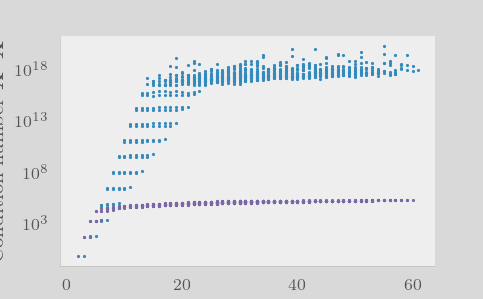

In [79]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    ax.scatter(runner.df['complexity'], cond_ols, s=1, label="OLS")
    ax.scatter(runner_r.df['complexity'], cond_ridge, s=1, label="Ridge")
    #ax.scatter(runner2.df['complexity'], cond2, s=1, label="Interactions")
    ax.set_xlabel('$p$')
    ax.set_ylabel(r'Condition number $\mathbf{X}^T\mathbf{X}$')
    ax.set_yscale('log')
    #ax.set_ylim(0, 50)
    #ax.set_xlim(0,50)
    fig.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.3, 1.02, 1, 0.2))
    fig.savefig(fig_path / "condition_ridge.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


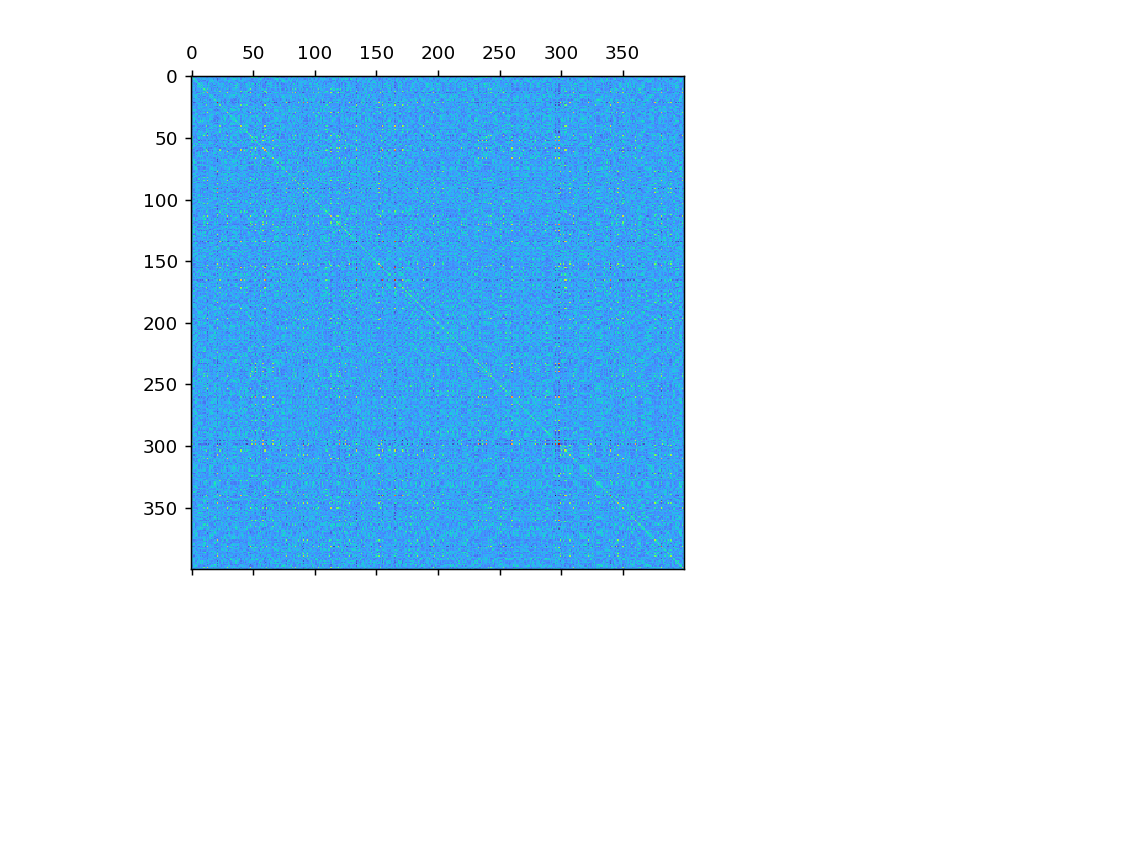

3835108.1193795605
-0.02912842021475034
2.927129543606152e-19


In [49]:
fig, ax = plt.subplots()
x = model.vandermonde
print(np.linalg.cond(x.T@x))
H = x@np.linalg.inv(x.T@x)@x.T
print(H.min())
print(np.sum((H - H@H)**2))
ax.matshow(H, cmap='turbo')

<IPython.core.display.Javascript object>


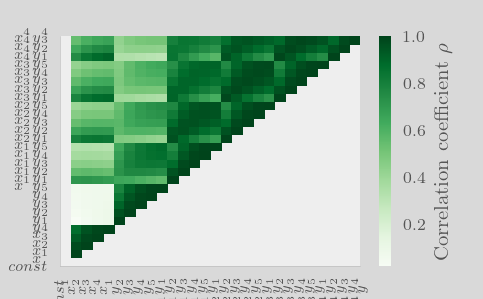

In [46]:
from scipy.stats import pearsonr
from itertools import product
model = runner.best_model('train')
cols = list(range(model.vandermonde.shape[1]))
corr = np.zeros((model.vandermonde.shape[1],)*2)
for i, j in product(cols, cols):
    if j > i:
        corr[i, j] = np.NaN
    else:
        corr[i, j] = pearsonr(model.vandermonde[:, i], model.vandermonde[:, j])[0]
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    beta = list(f"${key}$" for key in model.betadict().keys())
    cax = ax.pcolormesh(beta, beta, corr, cmap='Greens')
    ax.set_xticklabels(beta, rotation=90)
    cb = fig.colorbar(cax)
    cb.ax.set_ylabel(r'Correlation coefficient $\rho$')
    cb.outline.set_linewidth(0)
    ax.tick_params(axis='both', which='major', labelsize=7)
    fig.savefig(fig_path / "correlation.png", dpi=300, transparent=True, bbox_inches='tight')

## Part b)  Resampling

In [9]:
from sampler import Sampler
from tqdm import tqdm
from modelselection import kfold_indices
sampler = Sampler(franke)
sampler.set_noise(0.1)

# For use in model training and testing
(x_noise, y_noise), z_noise = sampler.sample(100)
# For comparing the K-fold MSE to the "actual" MSE
(x_pred, y_pred), z_pred = sampler.sample(500)

X, Y = list(range(1, 6)), list(range(1, 6))
XY = list(product(X, Y))

X, Y = [], []
MSE_test_k = []
MSE_train_k = []
MSE_test = []
MSE_train = []
MSE_pred_k = []
MSE_pred = []
Complexity = []
for order_x, order_y in tqdm(XY):
    max_interactions = range(1, order_x*order_y)
    for max_int in max_interactions:
        MSE_train_k.append([])
        MSE_test_k.append([])
        MSE_pred_k.append([])
        for train, test in kfold_indices(x_noise, k=5):
            reg = statistics.Regressor([x_noise[train], y_noise[train]], z_noise[train])
            reg.fit([order_x, order_y], max_interaction=max_int)
            MSE_train_k[-1].append(reg.mse())
            MSE_test_k[-1].append(reg.mse([x_noise[test], y_noise[test]], z_noise[test]))
            prediction_mse = reg.mse([x_pred, y_pred], z_pred)
            MSE_pred_k[-1].append(prediction_mse)
        complexity = reg.vandermonde.shape[1]
        MSE_train.append(np.mean(MSE_train_k[-1]))
        MSE_test.append(np.mean(MSE_test_k[-1]))
        MSE_pred.append(np.mean(MSE_pred_k[-1]))
        Complexity.append(complexity)
        X.append(order_x)
        Y.append(order_y)

100%|██████████| 25/25 [00:01<00:00,  6.78it/s]


In [10]:
def mean(array, index_array, val):
    array = np.asarray(array)
    return np.mean(array[index_array == val])

MSE_train_mean = []
MSE_test_mean = []
MSE_pred_mean = []
unique_complexity = np.sort(np.unique(Complexity))
for complexity in unique_complexity:
    MSE_train_mean.append(mean(MSE_train, Complexity, complexity))
    MSE_test_mean.append(mean(MSE_test, Complexity, complexity))
    MSE_pred_mean.append(mean(MSE_pred, Complexity, complexity))

<IPython.core.display.Javascript object>


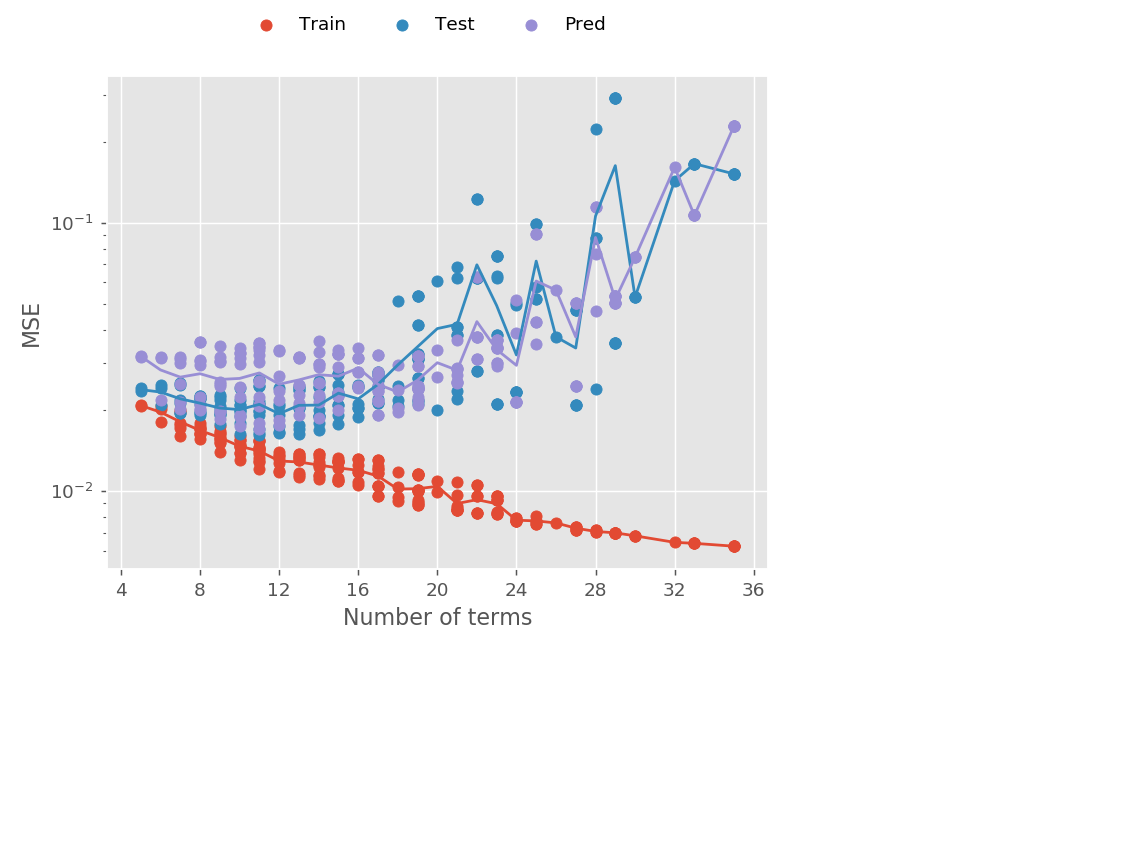

In [14]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    ax.scatter(Complexity, MSE_train, label='Train')
    ax.plot(unique_complexity, MSE_train_mean)
    ax.scatter(Complexity, MSE_test, label='Test')
    ax.plot(unique_complexity, MSE_test_mean)
    ax.scatter(Complexity, MSE_pred, label='Pred')
    ax.plot(unique_complexity, MSE_pred_mean)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('MSE')
    ax.set_xlabel("Number of terms")
    ax.set_yscale('log')
    fig.legend(loc=9, ncol=3, frameon=False)


## Part d) Bias-Variance Tradeoff

In [3]:
from ensemble import Ensemble

In [21]:
np.random.seed(14)
sampler = Sampler(franke)
#sampler.set_noise(0.1)
ensemble = Ensemble(sampler, order=13, sample_size=50, num_members=500)
ensemble.run(lambda *args: Ridge(*args, parameter=1e-3))

<IPython.core.display.Javascript object>


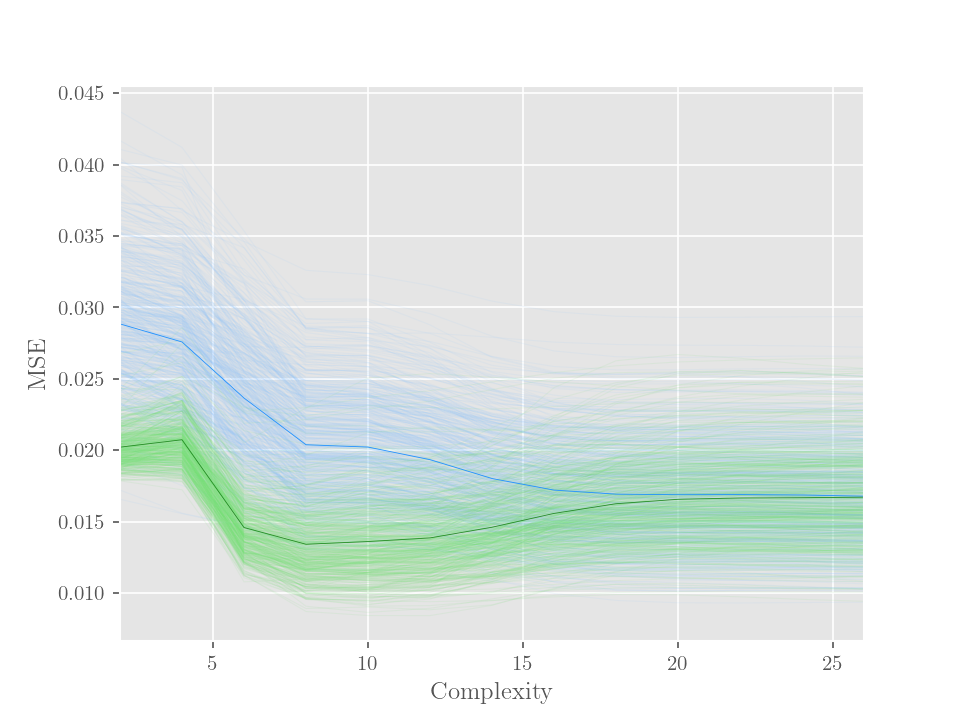

<IPython.core.display.Javascript object>


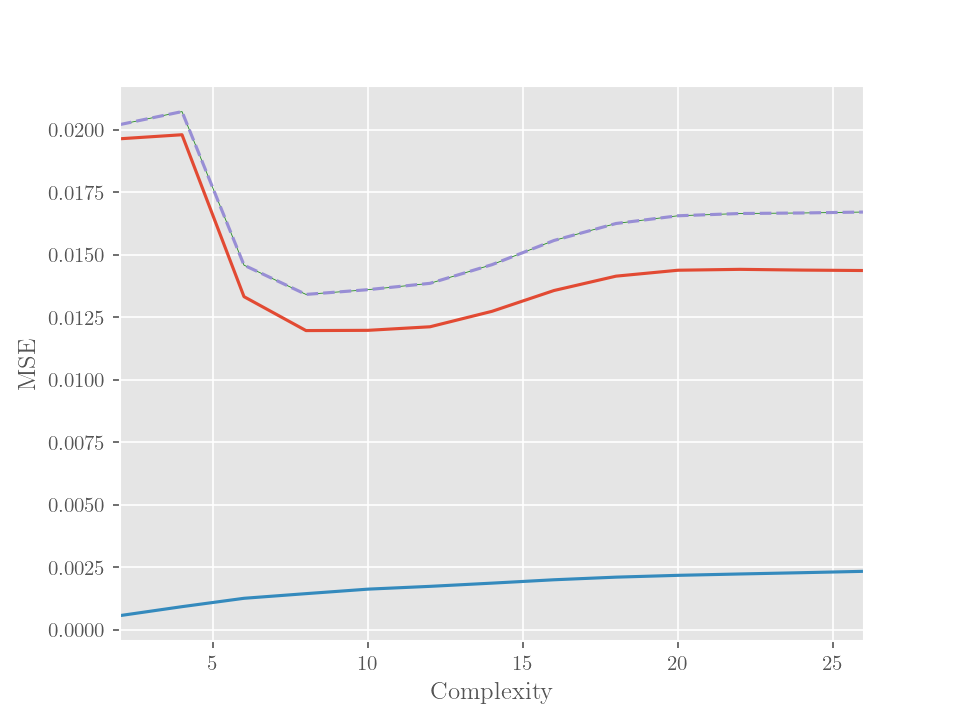

In [23]:
with plt.style.context('ggplot'):
    #fig, ax = plt.subplots(constrained_layout=True)
    fig, ax = ensemble.plot_train_test()
    #ax.set_ylim(0.0, 0.1)
    ax.set_xlim(2, 26)
    #fig.patch.set_visible(False)
    #fig.savefig(fig_path / "testrainmse.png", dpi=300, transparent=True, bbox_inches='tight')
    #fig, ax = plt.subplots()
    fig, ax = ensemble.plot_decomposition()
    #ax.set_ylim(0.0, 0.03)
    ax.set_xlim(2, 26)
    fig.patch.set_visible(False)
    #fig.savefig(fig_path / "testbiasvariance.png", dpi=300, transparent=True, bbox_inches='tight')

## Part d) Ridge

In [16]:
np.random.seed(25)
sampler = Sampler(franke)
sampler.set_noise(0.1)
Λ = np.append(0, np.logspace(-10, 2, 100))
ridge_runner = Runner(sampler, Ridge, parameter_range=Λ,
                find_prediction_error=True)
ridge_runner.sample(100)
ridge_runner.run([5, 5], single=True, use_interactions=True)

In [120]:
ridge_runner.df

parameter   MSE train   MSE test     train sd    test sd complexity  \
0              0  0.00686135    1.05257   0.00076032    1.47845         35   
1          1e-10  0.00727076    3.55193    0.0005402    4.80912         35   
2     1.2045e-10  0.00729189    3.60584  0.000527142    4.95164         35   
3    1.45083e-10  0.00731122    3.64874   0.00051546    5.08577         35   
4    1.74753e-10   0.0073289    3.68192  0.000505048    5.21331         35   
..           ...         ...        ...          ...        ...        ...   
96    0.00475081   0.0117921  0.0284945  0.000787094  0.0213481         35   
97    0.00572237   0.0120697  0.0283011  0.000801619   0.020227         35   
98    0.00689261   0.0123701   0.028081  0.000810462   0.019017         35   
99    0.00830218   0.0126898  0.0278349  0.000812349   0.017734         35   
100         0.01   0.0130243  0.0275635  0.000806471  0.0163969         35   

          df max x max y     const  ...    x^4y^1     x^4y^2    x^4y^3  \
0    34.9994     5     5  0.452099  ...   3113.27   -13990.4   27342.9   
1    33.9282     5     5  0.452099  ...   765.356   -2901.35   4862.62   
2    33.8789     5     5  0.452099  ...   687.514   -2537.62   4131.71   
3     33.827     5     5  0.452099  ...   618.481   -2216.42    3488.6   
4    33.7718     5     5  0.452099  ...   557.567   -1934.51   2926.65   
..       ...   ...   ...       ...  ...       ...        ...       ...   
96   16.4881     5     5   0.45522  ...  0.736548  -0.143148 -0.417552   
97   16.2364     5     5   0.45522  ...  0.705961  -0.123383 -0.357797   
98    15.982     5     5   0.45522  ...  0.671838  -0.105762 -0.301992   
99   15.7244     5     5   0.45522  ...  0.634928   -0.08976  -0.25028   
100  15.4631     5     5   0.45522  ...  0.595953 -0.0749931  -0.20284   

       x^4y^4    x^4y^5    x^5y^1    x^5y^2     x^5y^3    x^5y^4    x^5y^5  
0    -24734.9   8521.85  -1173.47   5101.66    -9689.8   8551.03   -2883.8  
1    -3958.73   1300.42  -287.226   1001.91   -1561.73   1206.52  -385.404  
2    -3288.35   1068.92  -257.963   868.044    -1298.7   970.637  -305.674  
3    -2700.34   866.411  -232.052   750.048    -1067.7   764.123  -236.056  
4    -2188.57   690.766  -209.239   646.745   -866.387   584.869  -175.833  
..        ...       ...       ...       ...        ...       ...       ...  
96  -0.470932 -0.744542 -0.860663 -0.480839    0.12331  0.619474  0.776626  
97    -0.4065 -0.681342  -0.81968  -0.48027  0.0972667  0.568824  0.713521  
98  -0.344255 -0.618076 -0.772527 -0.478533  0.0700252  0.518393  0.652056  
99  -0.285142 -0.555429 -0.720955 -0.474996  0.0424804  0.468518  0.592757  
100 -0.230014 -0.494188  -0.66677 -0.469112  0.0155868  0.419688   0.53608  

[101 rows x 45 columns]

<IPython.core.display.Javascript object>


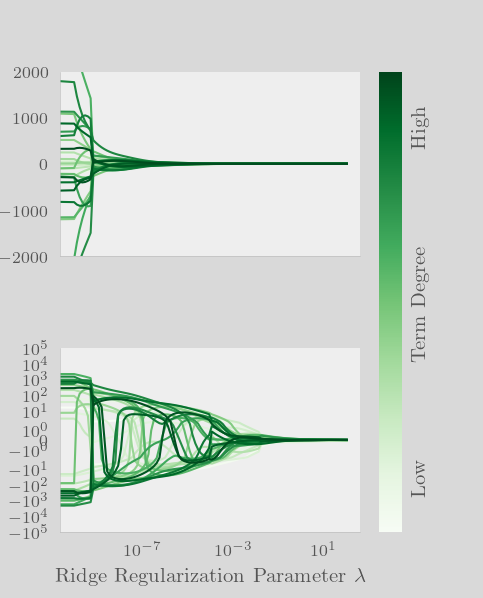

In [65]:
#with plt.style.context('rapport'):
    #fig, ax = plt.subplots(figsize=(fig_size[0], 2*fig_size[1]))
    #fig, ax = ridge_runner.coeff_plot(ax = ax)
   # ax.set_xscale('symlog')
  #  ax.xaxis.set_major_formatter(MyLogFormatter())
    #matplotlib.rcParams['axes.unicode_minus'] = True
 #   ax.tick_params(axis='x', which='major', labelsize=5)
 #   fig.savefig(fig_path / "ridgecoeff.png", dpi=300, transparent=True, bbox_inches='tight')

with plt.style.context('rapport'):
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(fig_size[0], 2*fig_size[1]))
    ridge_runner.coeff_evolution(ax[0])
    ridge_runner.coeff_evolution(ax[1])
    ax[1].set_xlabel("Ridge Regularization Parameter $\lambda$")
    ax[1].set_xscale('log')
    ax[1].set_yscale('symlog')
    ax[0].set_ylim(-2000, 2000)
    sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=0, vmax=1))
    cb = fig.colorbar(sm, ax=ax.ravel().tolist())
    cb.outline.set_linewidth(0)
    cb.set_ticks([])
    cb.ax.set_ylabel('Low $\\qquad\\qquad$ Term Degree $\\qquad\\qquad$ High')

    #fig.text(0.03, 0.4, 'Coefficient Value', ha='center', rotation='vertical')
    fig.savefig(fig_path / "ridgecoeff_evo.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


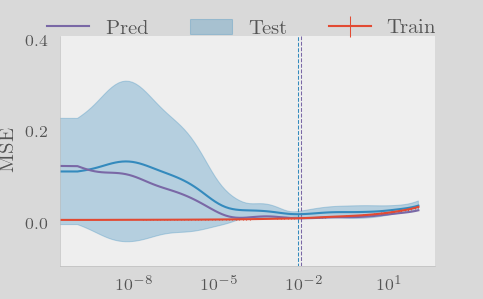

In [5]:
with plt.style.context('rapport'):
    fig, ax = ridge_runner.mse_plot()
    ax.set_xlabel('Ridge Regularization Parameter $\lambda$')
    fig.savefig(fig_path / "ridgemse.png", dpi=300, transparent=True, bbox_inches='tight')


<IPython.core.display.Javascript object>


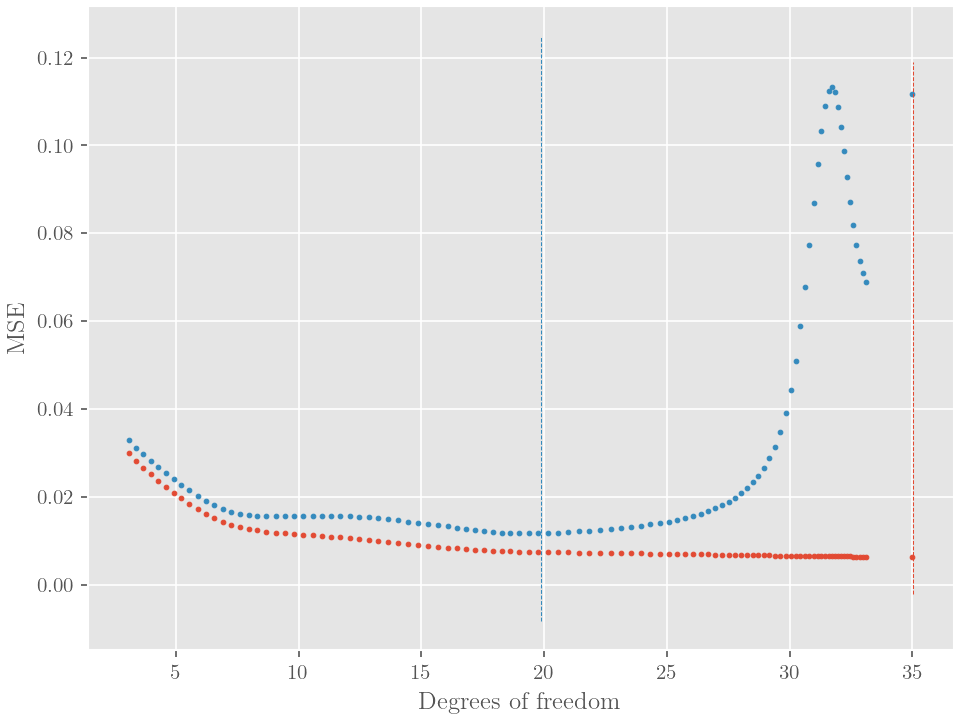

In [132]:
testbest = ridge_runner.best_model('test').df()
trainbest = ridge_runner.best_model('train').df()
#predbest = ridge_unner.best_model('pred').df()
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True)
    tr = ax.scatter(ridge_runner.df['df'], ridge_runner.df['MSE train'], label='Train', s=5)
    te = ax.scatter(ridge_runner.df['df'], ridge_runner.df['MSE test'], label='Test', s=5)
    #pr = ax.scatter(runner.df['df'], runner.df['MSE pred'], label='Outsample test', s=5)
    ax.vlines(trainbest, *ax.get_ylim(), color=tr.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.vlines(testbest, *ax.get_ylim(), color=te.get_facecolor(), linewidth=0.5, linestyle='--')
    #ax.vlines(predbest, -1, 0.2, color=pr.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.set_xlabel("Degrees of freedom")
    #ax.set_ylim(0, 0.1)
    ax.set_ylabel("MSE")
    fig.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.02, 1, 0.2))

<IPython.core.display.Javascript object>


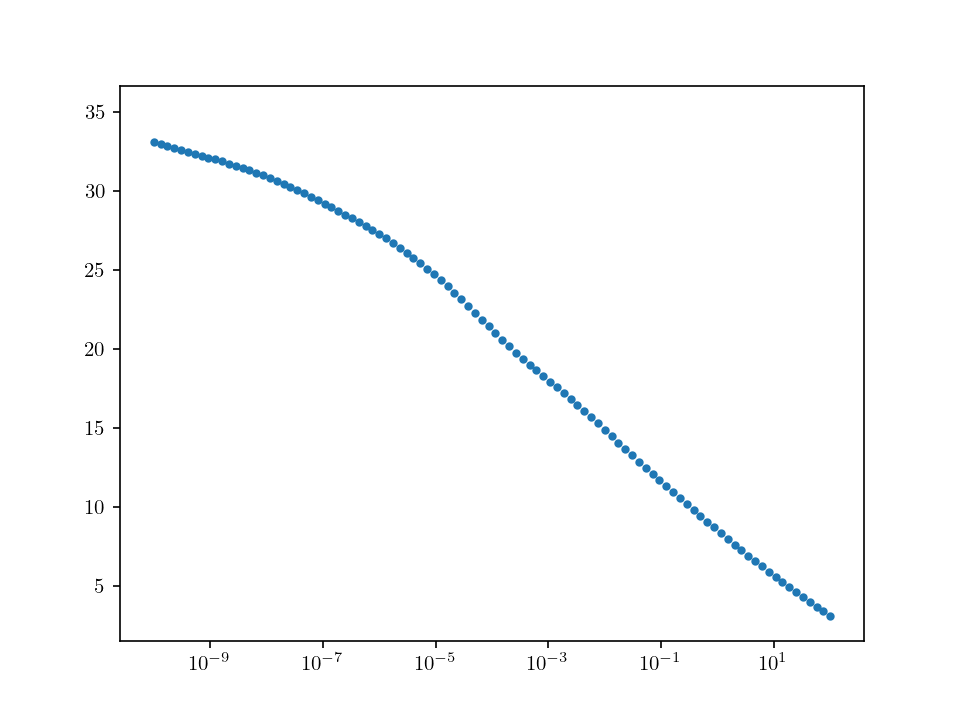

In [143]:
fig, ax = plt.subplots()
ax.plot(parameters, df, '.')
ax.set_xscale('log')

<IPython.core.display.Javascript object>


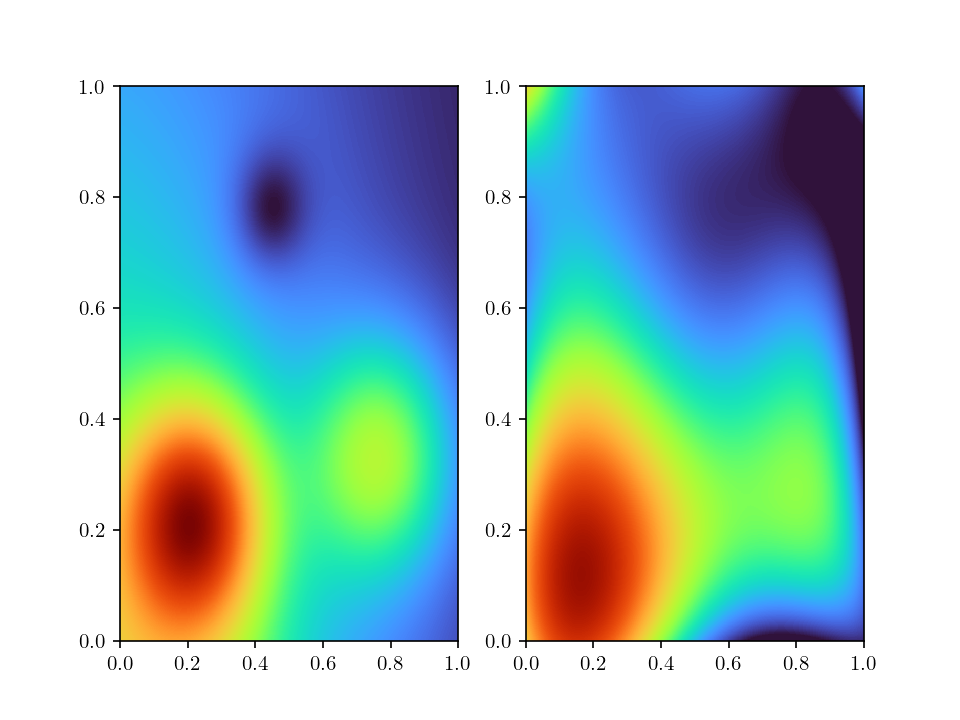

(<Figure size 640x480 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f495475b890>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f495475b490>))

In [18]:
ridge_runner.compare_plot()

## Part e) Lasso

In [3]:
np.random.seed(15)
sampler = Sampler(franke)
sampler.set_noise(0.1)
alphas = np.logspace(-4, 0, 300)
lasso_runner = Runner(sampler, Lasso, parameter_range=alphas,
                find_prediction_error=True)
lasso_runner.sample(100)
lasso_runner.run([5, 5], single=True)

<IPython.core.display.Javascript object>


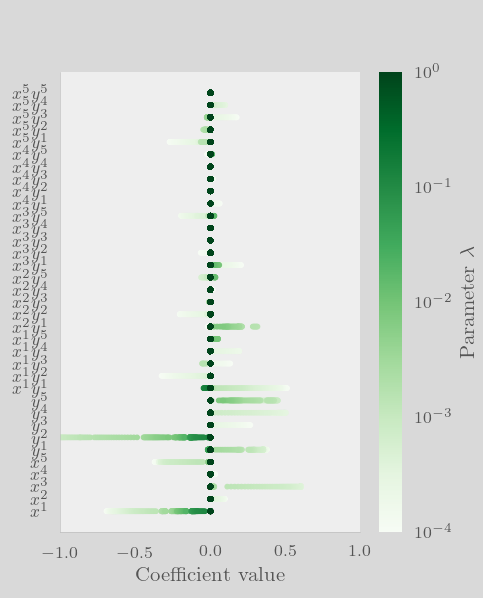

<IPython.core.display.Javascript object>


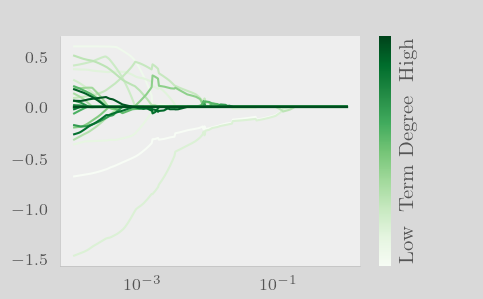

In [23]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize=(fig_size[0], 2*fig_size[1]))
    fig, ax = lasso_runner.coeff_plot(ax = ax)
    ax.set_xscale('linear')
    ax.set_xlim(-1, 1)
    ax.set_xticks([-1, 1], [-1, 1])
    #ax.xaxis.set_major_formatter(MyLogFormatter())
    #matplotlib.rcParams['axes.unicode_minus'] = True
    #ax.tick_params(axis='x', which='major', labelsize=5)
    fig.savefig(fig_path / "lassocoeff.png", dpi=300, transparent=True, bbox_inches='tight')

with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    lasso_runner.coeff_evolution(ax)
    #lasso_runner.coeff_evolution(ax[1])
    ax.set_xlabel("Lasso Regularization Parameter $\\alpha$")
    ax.set_xscale('log')
    #ax.set_yscale('symlog')
    #ax[0].set_ylim(-2000, 2000)
    sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=0, vmax=1))
    cb = fig.colorbar(sm, ax=ax)#.ravel().tolist())
    cb.outline.set_linewidth(0)
    cb.set_ticks([])
    cb.ax.set_ylabel('Low $ $ Term Degree $ $ High')

    #fig.text(0.03, 0.4, 'Coefficient Value', ha='center', rotation='vertical')
    fig.savefig(fig_path / "lassocoeff_evo.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


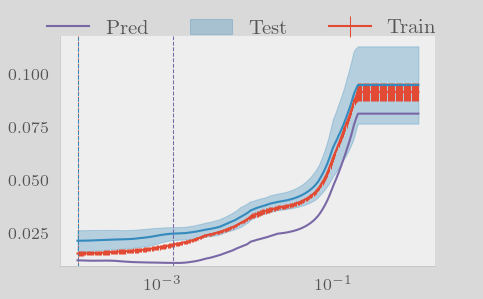

In [10]:
with plt.style.context('rapport'):
    fig, ax = lasso_runner.mse_plot()
    ax.set_xlabel(r'Lasso Regularization Parameter $\alpha$')
    fig.savefig(fig_path / "lassomse.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


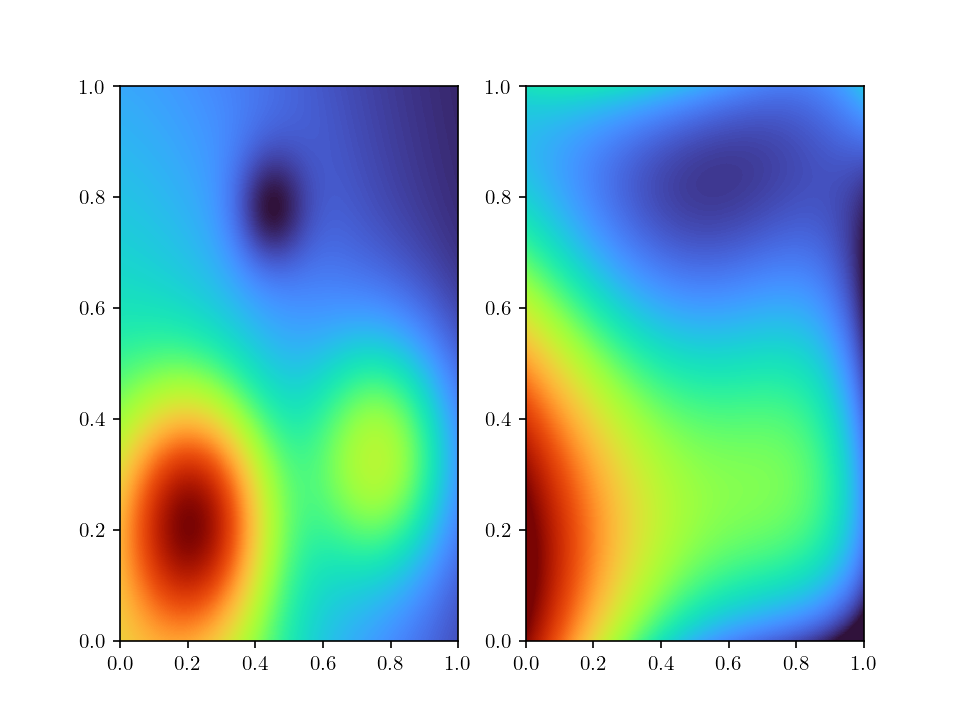

(<Figure size 640x480 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f9266daa8d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9266d87350>))

In [36]:
lasso_runner.compare_plot(use_3d=False)

<IPython.core.display.Javascript object>


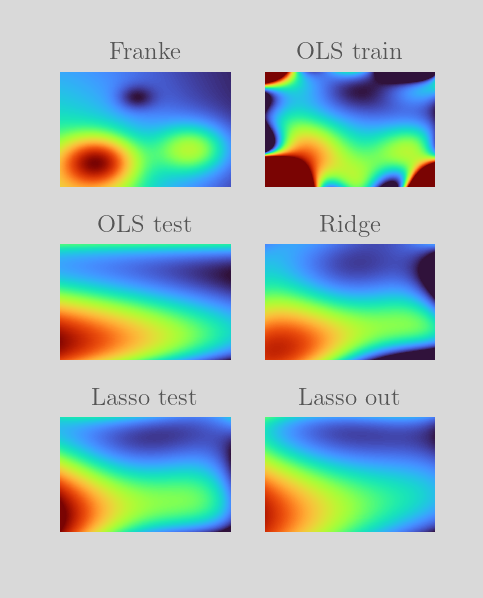

In [30]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(fig_size[0], 2*fig_size[1]))
    runner.compare_plot(ax=ax[0, :], which='train')
    runner.compare_plot(ax=[ax[0, 0], ax[1, 0]], which='test')
    ridge_runner.compare_plot(ax=[ax[0, 0], ax[1, 1]])
    lasso_runner.compare_plot(ax=[ax[0, 0], ax[2, 0]])
    lasso_runner.compare_plot(ax=[ax[0, 0], ax[2, 1]], which='pred')
    ax[0, 0].set_title('Franke')
    ax[0, 1].set_title('OLS train')
    ax[1, 0].set_title('OLS test')
    ax[1, 1].set_title('Ridge')
    ax[2, 0].set_title('Lasso test')
    ax[2, 1].set_title('Lasso out')
    for a in ax.ravel():
        a.axis('off')
    fig.savefig(fig_path / "comparisons.png", dpi=300, transparent=True, bbox_inches='tight')

In [38]:
lasso_runner.best_model('test').betadict()

{'const': 0.43073674287468167,
 'x^1': -0.6932341755784623,
 'x^2': 0.09622555251455377,
 'x^3': 0.6032738658692575,
 'x^4': 0.03267670796075188,
 'x^5': -0.3729617758426083,
 'y^1': 0.37569994657285816,
 'y^2': -1.4833160137914114,
 'y^3': 0.2662166632884224,
 'y^4': 0.4135279121594031,
 'y^5': 0.08990770978329578,
 'x^1y^1': 0.5107242884459456,
 'x^1y^2': -0.32619095403852566,
 'x^1y^3': 0.13228765723123917,
 'x^1y^4': 0.18332552790490905,
 'x^1y^5': -0.0,
 'x^2y^1': -0.01903647426392209,
 'x^2y^2': -0.20519699234957023,
 'x^2y^3': 0.0,
 'x^2y^4': 0.01559849135921403,
 'x^2y^5': -0.01136096810244611,
 'x^3y^1': 0.20482337067928488,
 'x^3y^2': -0.06567988675583956,
 'x^3y^3': -0.0,
 'x^3y^4': -0.0,
 'x^3y^5': -0.18187071421599027,
 'x^4y^1': 0.062036030770587815,
 'x^4y^2': 0.0,
 'x^4y^3': 0.01601030898098671,
 'x^4y^4': 0.0006463156864043002,
 'x^4y^5': -0.023314989179437837,
 'x^5y^1': -0.27306971620965864,
 'x^5y^2': -0.0,
 'x^5y^3': 0.17536131757103546,
 'x^5y^4': 0.06124775004135

<IPython.core.display.Javascript object>


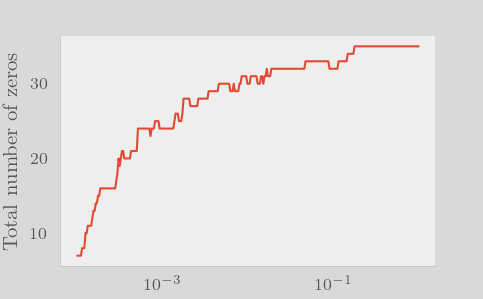

In [14]:
term_cols = [term for term in lasso_runner.df.columns if '^' in term]
lasso_runner.df['zeros'] = (lasso_runner.df[term_cols] == 0).sum(axis=1)
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    ax.plot(lasso_runner.df['parameter'], lasso_runner.df['zeros'])
    ax.set_xscale('log')
    ax.set_xlabel("Lasso Regularization Parameter $\\alpha$")
    ax.set_ylabel("Total number of zeros")
    fig.savefig(fig_path / "zeros.png", dpi=300, transparent=True, bbox_inches='tight')

## Part g) Geographical Data

(3601, 1801)
(73, 36)
2628


<IPython.core.display.Javascript object>


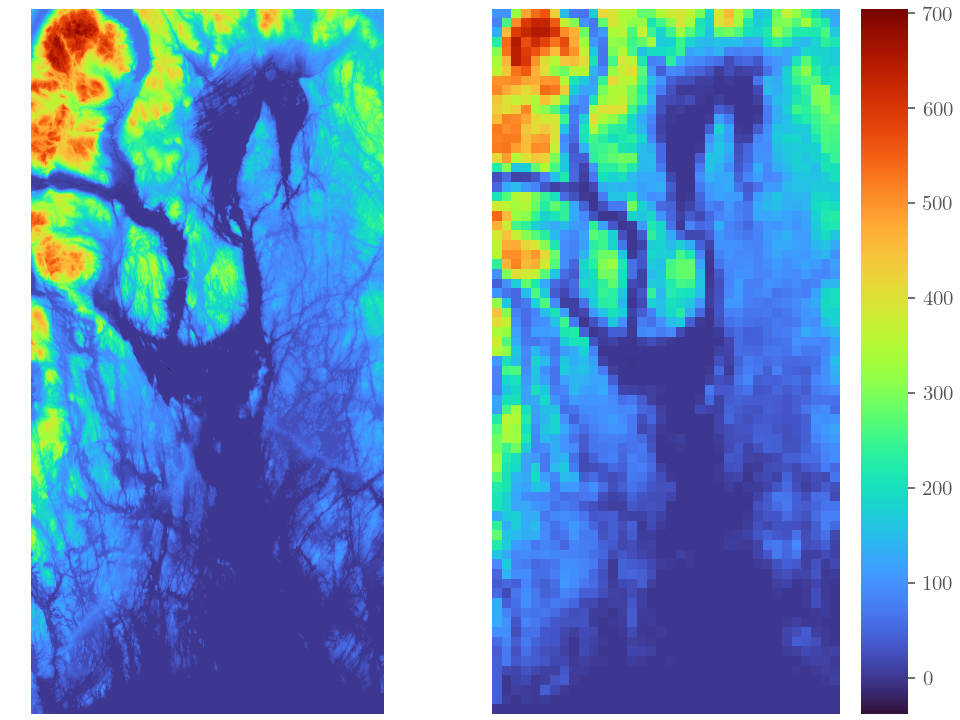

In [3]:
from skimage.measure import block_reduce
# Load the terrain
terrain = imread('../resources/n59_e010_1arc_v3.tif')
# Downsample
shape = (50, 50)
subterrain = block_reduce(terrain, block_size=shape, func=np.mean)
subterrain = subterrain[:, :-1]
print(terrain.shape)
print(subterrain.shape)
print(subterrain.shape[0] * subterrain.shape[1])
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(ncols=2, constrained_layout=True)
    vmin, vmax = terrain.min(), terrain.max()
    ax[0].imshow(terrain, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[0].axis('off')
    cax = ax[1].imshow(subterrain, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[1].axis('off')
    cb = fig.colorbar(cax)
    cb.outline.set_linewidth(0) 
    #fig.savefig(fig_path / "terrain.png", dpi=300, transparent=True)
    #fig.savefig(;)

In [15]:
np.random.seed(1)
sampler = Sampler(subterrain)
#geo_reg = Runner(sampler, Ridge, [1e-7, 1e-3])
geo_reg = Runner(sampler, Regressor)
geo_reg.sample(300)
geo_reg.run([5, 5], single=False, use_interactions=True)
geo_reg.df

parameter MSE train MSE test train sd  test sd complexity  df max x max y  \
0         NaN   7321.64  7537.48  431.406  1762.28          4   4     1     1   
1         NaN   5093.03  5358.85  474.729  2024.87          5   5     1     2   
2         NaN    4635.7  5033.14  544.758  2394.44          6   6     1     2   
3         NaN   5057.19  5460.46  457.671  2014.32          6   6     1     3   
4         NaN   4610.27  5135.14  536.881  2426.32          7   7     1     3   
..        ...       ...      ...      ...      ...        ...  ..   ...   ...   
220       NaN   3291.17  6406.63  311.787  5254.49         35  35     5     5   
221       NaN   3291.17  6406.63  311.787  5254.49         35  35     5     5   
222       NaN   3291.17  6406.63  311.787  5254.49         35  35     5     5   
223       NaN   3291.17  6406.63  311.787  5254.49         35  35     5     5   
224       NaN   3239.72   6277.8  298.805  4446.63         36  36     5     5   

     r2 train  ...   x^4y^1  x^4y^2       x^4y^3      x^4y^4   x^4y^5  \
0    0.581887  ...      NaN     NaN          NaN         NaN      NaN   
1    0.709124  ...      NaN     NaN          NaN         NaN      NaN   
2    0.735151  ...      NaN     NaN          NaN         NaN      NaN   
3    0.711118  ...      NaN     NaN          NaN         NaN      NaN   
4    0.736574  ...      NaN     NaN          NaN         NaN      NaN   
..        ...  ...      ...     ...          ...         ...      ...   
220   0.81176  ...  -207081  576393      -601062      230356 -24409.7   
221   0.81176  ...  -207081  576393      -601062      230356 -24409.7   
222   0.81176  ...  -207081  576393      -601062      230356 -24409.7   
223   0.81176  ...  -207081  576393      -601062      230356 -24409.7   
224  0.814649  ... -62084.3 -247879  1.33382e+06 -1.7355e+06   695088   

      x^5y^1  x^5y^2  x^5y^3   x^5y^4  x^5y^5  
0        NaN     NaN     NaN      NaN     NaN  
1        NaN     NaN     NaN      NaN     NaN  
2        NaN     NaN     NaN      NaN     NaN  
3        NaN     NaN     NaN      NaN     NaN  
4        NaN     NaN     NaN      NaN     NaN  
..       ...     ...     ...      ...     ...  
220  64914.5 -178294  175187 -53710.2     NaN  
221  64914.5 -178294  175187 -53710.2     NaN  
222  64914.5 -178294  175187 -53710.2     NaN  
223  64914.5 -178294  175187 -53710.2     NaN  
224  10722.9  129859 -546501   677553 -266950  

[225 rows x 47 columns]

<IPython.core.display.Javascript object>


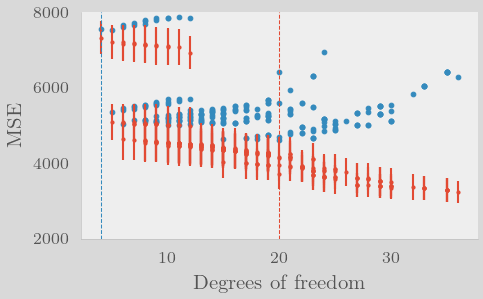

In [39]:
testbest = geo_reg.best_model('test').df()
trainbest = geo_reg.best_model('train').df()
#predbest = geo_reg.best_model('pred').df()
with plt.style.context('rapport'):
    fig, ax = plt.subplots(constrained_layout=True)
    tr, _, _ = ax.errorbar(geo_reg.df['df'], geo_reg.df['MSE train'], 
                     geo_reg.df['train sd'], label='Train', fmt='o', ms=1,
                          linewidth=1, c="#E24A33")
    te = ax.scatter(geo_reg.df['df'], geo_reg.df['MSE test'], label='Test', s=5,
                   c='#348ABD')
    #pr = ax.scatter(geo_reg.df['df'], geo_reg.df['MSE pred'], label='Out of Sample',
     #               s=5, c='#7A68A6')
    ax.vlines(trainbest, 2000, 8000, color=tr.get_color(), linewidth=0.5, linestyle='--')
    ax.vlines(testbest, 2000, 8000, color=te.get_facecolor(), linewidth=0.5, linestyle='--')
    #ax.vlines(predbest+0.1, -1, 0.2, color=pr.get_facecolor(), linewidth=0.5, linestyle='--')
    ax.set_xlabel("Degrees of freedom")
    ax.set_ylim(2000, 8000)
    ax.set_ylabel("MSE")
    fig.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.3, 1.02, 1, 0.2))
    fig.savefig(fig_path / "geo_reg_mse.png", dpi=300, transparent=True, bbox_inches='tight')

In [5]:
Λ = np.append(0, np.logspace(-10, 2, 100))
geo_ridge = Runner(sampler, Ridge, parameter_range=Λ)
geo_ridge.sample(300)
geo_ridge.run([15, 15], single=True, use_interactions=True)

In [44]:
Λ = np.logspace(-10, 1, 300)
geo_lasso = Runner(sampler, Lasso, parameter_range=Λ)
geo_lasso.sample(300)
geo_lasso.run([15, 15], single=True, use_interactions=True)

<IPython.core.display.Javascript object>


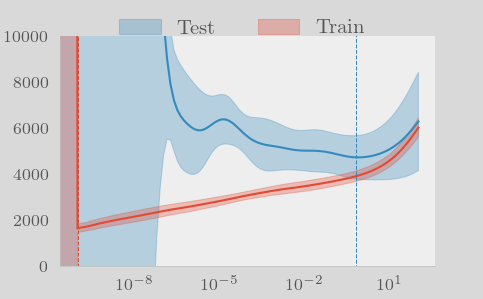

<IPython.core.display.Javascript object>


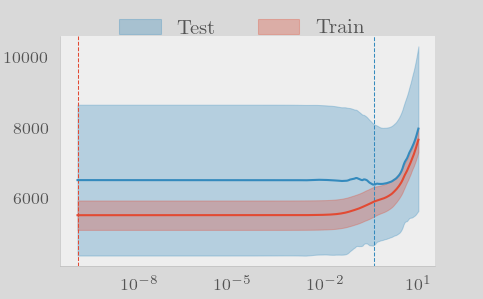

In [45]:
with plt.style.context('rapport'):
    fig, ax = geo_ridge.mse_plot()
    ax.set_ylim(0, 1e4)
    ax.set_xlabel('Ridge Regularization Parameter $\\lambda$')
    fig.savefig(fig_path / "geo_ridge_mse.png", dpi=300, transparent=True, bbox_inches='tight')
    fig, ax = geo_lasso.mse_plot()
    ax.set_xlabel('Lasso Regularization Parameter $\\alpha$')
    fig.savefig(fig_path / "geo_lasso_mse_2.png", dpi=300, transparent=True, bbox_inches='tight')
    

In [27]:
geo_large = Runner(sampler, Regressor)
geo_large.sample(800)
geo_large.run([15, 15], single=True, use_interactions=True)

<IPython.core.display.Javascript object>


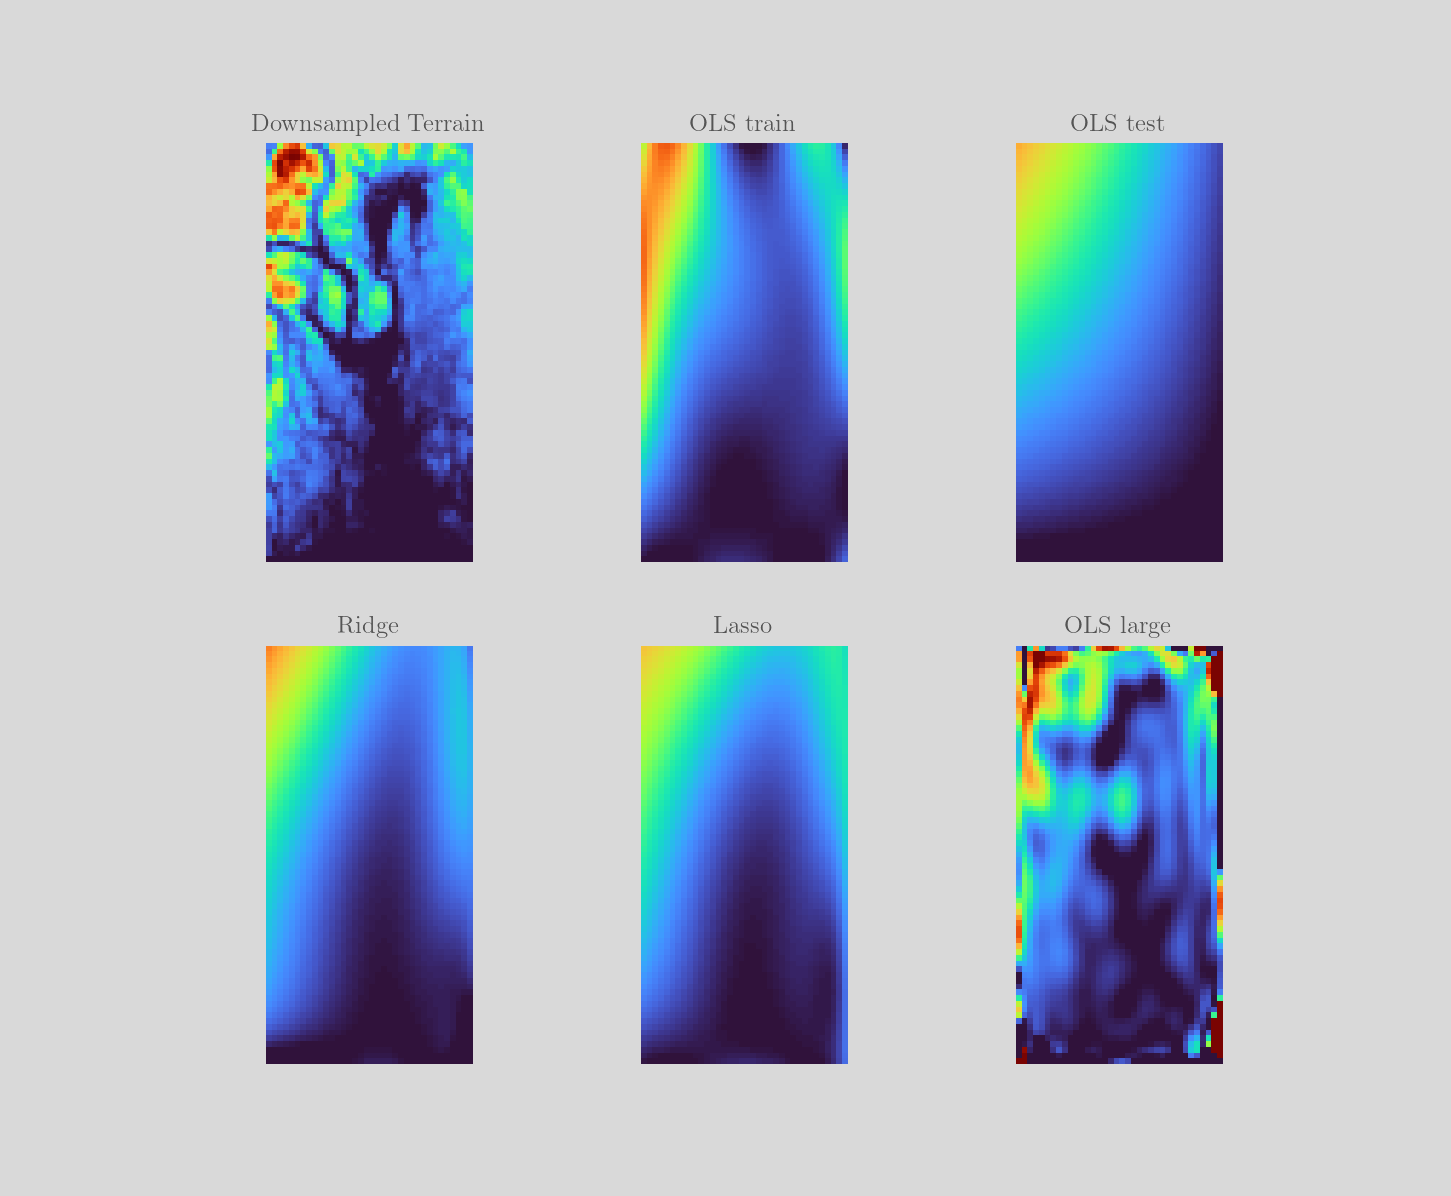

In [43]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(3*fig_size[0], 4*fig_size[1]))
    ax = ax.ravel()
    geo_reg.compare_plot(ax=ax[:2], which='train')
    geo_reg.compare_plot(ax=[ax[0], ax[2]], which='test')
    geo_ridge.compare_plot(ax=[ax[0], ax[3]])
    geo_lasso.compare_plot(ax=[ax[0], ax[4]])
    geo_large.compare_plot(ax=[ax[0], ax[5]])
    #geo_lasso.compare_plot(ax=[ax[0, 0], ax[2, 1]], which='pred')
    ax[0].set_title('Downsampled Terrain')
    ax[1].set_title('OLS train')
    ax[2].set_title('OLS test')
    ax[3].set_title('Ridge')
    ax[4].set_title('Lasso')
    ax[5].set_title('OLS large')
    for a in ax:
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.2)
    fig.savefig(fig_path / "geo_comparisons.png", dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


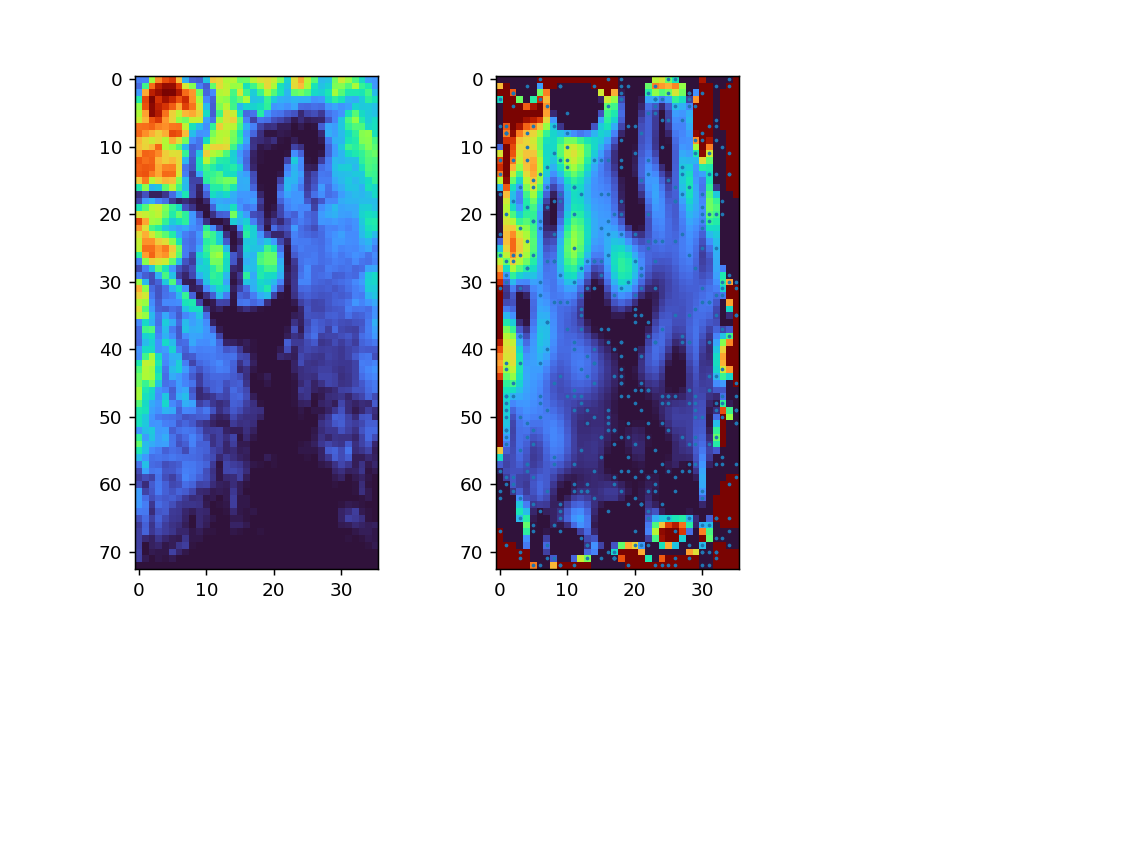

In [32]:
shape = geo_reg.best_model().vandermonde.shape
#print(geo_reg.best_model().λ)
x, y = subterrain.shape
fig, ax = geo_reg.compare_plot()
ax[1].scatter(geo_reg.y*y, geo_reg.x*x, s=1)

# Todo
- [x] Show how bias-variance changes as the order changes for many ensembles.
- [x] Make confidence intervals.
- [x] Implement k-fold cross validation.
- [x] Implement Lasso and Ridge regression by subclassing.
- [x] Look at how the geo-data is structured.
- [x] Write tests
- [ ] Take a look at hypthesis
- %[ ] Make ensemble a context manager?%
- [x] Doesn't ksplit give the same as Ensemble? No
- My points are not randomly distributed in 2D, only in 1D. This
  creates a grid pattern and overfits along the grid while demanding too
  large matrices. The _meshgrid_ is the fault.
  - Fixed
- The fitting fails for the terrain when the degree goes above 6. Looks like 
ocilliations. A column that goes beserk?
- [x] Add interactions. Multiply the columns from vandermonde()
- [x] Standardize coefficients in the coefficient plot by subtracting by
vandermonde mean and divide by vandermonde std
- [x] Check whether or not the number of features > number of samples
- [x] Normalize design matrix and predictors
- [x] Fix Ridge variance (df)
- [x] Downsample
- [x] Standardize array code
- [ ] Show dependence on noise and number of samples on ci and t
- Innsikt i problemet skal generelt bestemme graden og type regressjon
- Sammenlige med noiseless for å sjekke beste-modell-reglen
- Finn influence til hvert punkt for en gitt modell og plott dette

## Testing of the code

<IPython.core.display.Javascript object>


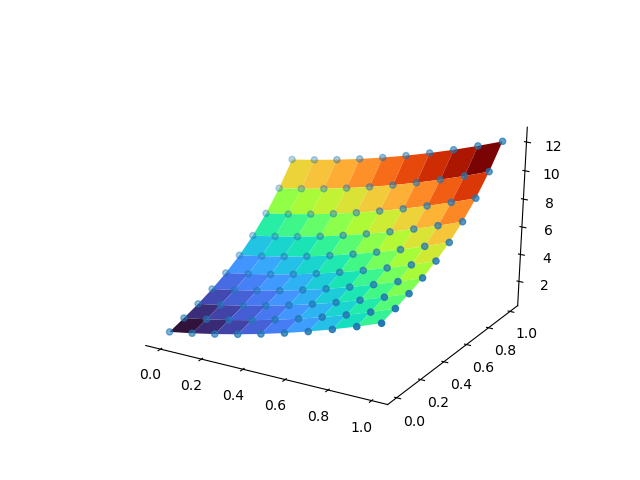

array([[ 1.00000000e+00,  1.00000000e+00],
       [ 2.50000000e+00,  2.50000000e+00],
       [ 1.70000000e+00,  1.70000000e+00],
       [-2.55935636e-14,  3.98044183e-14],
       [ 3.00000000e+00,  3.00000000e+00],
       [-4.45003962e-14,  5.51585372e-14],
       [ 4.00000000e+00,  4.00000000e+00]])

In [71]:
x, y = np.linspace(0, 1, 10), np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
f = lambda x, y: 1 + 2.5*x + 1.7*x**2 + 3*y + 4*y**3
Z = f(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='turbo')
remove_panes(ax)

reg = statistics.Regressor([X, Y], Z)
reg.fit([3, 3])
Ẑ = reg.predict([X, Y])
ax.scatter(X, Y, Ẑ)

reg.ci(0.85)

In [3]:
def remove_panes(ax):
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [72]:
df = pd.DataFrame(data=fitter.vandermonde, columns=['constant', 'x1', 'x2', 'x3', 'x4', 'x5',
                                                    'y1', 'y2', 'y3', 'y4', 'y5'])
df['response'] = fitter.response

In [73]:
res = smf.ols("response ~ x1 + x2 + x3 + x4 + x5 + y1 + y2 + y3 + y4 + y5", data=df).fit()

In [74]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     871.2
Date:                Sun, 01 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:19:01   Log-Likelihood:                 1310.5
No. Observations:                2500   AIC:                            -2599.
Df Residuals:                    2489   BIC:                            -2535.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5560      0.020     27.176      0.000       0.516       0.596
x1             2.6439      0.306      8.652      0.000       2.045       3.243
x2           -13.5097      1.942     -6.955      0.000     -17.318      -9.701
x3            19.9984      4.980      4.015      0.000      10.232      29.764
x4            -9.6557      5.512     -1.752      0.080     -20.464       1.153
x5             0.1244      2.193      0.057      0.955      -4.177       4.425
y1             1.6078      0.306      5.262      0.000       1.009       2.207
y2             1.6196      1.942      0.834      0.404      -2.189       5.428
y3           -25.0568      4.980     -5.031      0.000     -34.823     -15.291
y4            38.5517      5.512      6.994      0.000      27.743      49.360
y5           -17.0766      2.193     -7.785      0.000     -21.378     -12.776
==============================================================================
Omnibus:                        2.097   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                2.149
Skew:                           0.066   Prob(JB):                        0.341
Kurtosis:                       2.943   Cond. No.                     4.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""